# Attribute Importance for Concept Drift - Analysis on the BPI challenge 2018 dataset

The process drift explanation framework is applied on the process of EU direct payments for German farmers.

## Setup
### Imports

In [5]:
# imports
import helper
import math
import pm4py
import pandas as pd
import numpy as np
import time

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog
from pm4py.write import write_xes

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import population_comparison
from processdrift.framework import windowing
from processdrift.framework import change_point_extraction

### Data settings and event log loading

In [6]:
# specify the file paths for each municipal's log
file_path = 'data/real/bpic_2018/BPI Challenge 2018.xes'

In [7]:
# load the event logs
event_log = xes_importer.apply(file_path)

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 43809/43809 [04:48<00:00, 151.60it/s]


## Present basic analysis

In [4]:
def get_basic_stats(event_log, get_attribute_values=False):
    # get some basic statistics (number of events, number of traces, attributes...)
    basic_stats = {}

    # event statistics
    event_stream = pm4py.convert.convert_to_event_stream(event_log)
    number_events = len(event_stream)
    basic_stats['Number of events'] = number_events

    event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)

    if get_attribute_values:
        basic_stats['Event attributes'] = str(sorted(event_attributes))

    number_event_attributes = len(event_attributes)
    basic_stats['Number event attributes'] = number_event_attributes

    # trace statistics
    number_traces = len(event_log)
    basic_stats['Number traces'] = number_traces

    trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
    if get_attribute_values:
        basic_stats['Trace attributes'] = str(sorted(trace_attributes))

    number_trace_attributes = len(trace_attributes)
    basic_stats['Number trace attributes'] = number_trace_attributes

    basic_stats_series = pd.Series(basic_stats)
    return basic_stats_series

In [5]:
get_basic_stats(event_log)

Number of events           2514266
Number event attributes         12
Number traces                43809
Number trace attributes         61
dtype: int64

In [8]:
# check if all logs have the same event and trace attributes
event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)
trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
print(f'Event Attributes: {event_attributes}')
print(f'Trace Attributes: {trace_attributes}')

Event Attributes: {'identity:id', 'note', 'subprocess', 'eventid', 'concept:name', 'time:timestamp', 'success', 'activity', 'docid_uuid', 'doctype', 'docid', 'org:resource'}
Trace Attributes: {'penalty_JLP2', 'penalty_JLP3', 'applicant', 'area', 'penalty_amount2', 'penalty_AVGP', 'number_parcels', 'cross_compliance', 'penalty_amount0', 'penalty_C9', 'payment_actual2', 'penalty_JLP6', 'penalty_AGP', 'amount_applied3', 'identity:id', 'basic payment', 'risk_factor', 'selected_risk', 'payment_actual0', 'penalty_ABP', 'selected_manually', 'selected_random', 'greening', 'amount_applied1', 'penalty_C16', 'payment_actual3', 'penalty_C4', 'penalty_B5F', 'penalty_amount3', 'program-id', 'penalty_AVBP', 'amount_applied2', 'small farmer', 'penalty_JLP7', 'penalty_CC', 'penalty_B6', 'penalty_B2', 'penalty_GP1', 'redistribution', 'young farmer', 'application', 'amount_applied0', 'year', 'penalty_BGKV', 'penalty_BGK', 'penalty_V5', 'penalty_BGP', 'department', 'rejected', 'penalty_AVJLP', 'penalty_B3

In [9]:
display(helper.get_examples_of_event_attributes(event_log, 10, event_attributes))

,success,org:resource,docid_uuid,doctype,subprocess,docid,activity,note,eventid,identity:id,concept:name,time:timestamp
0,True,Document processing automaton,4CD2E82F-6A54-44C6-97F7-82FDB97CBE9F,Geo parcel document,Main,-18008532115293966,initialize,none,-18008532115293964,810952F9-470A-4486-BE4E-770C9C3896F8,initialize,2016-06-22 16:42:07.888000+02:00
1,True,DP-Z,4870E98F-263B-4549-862A-BAA055562D0B,Payment application,Application,-18008611495975467,begin payment,automatic during payment,-18008596977134796,B45B5A44-5399-4A89-B0C5-DCF92762341D,begin payment,2015-12-18 14:32:38.575000+01:00
2,True,727350,0C13D094-E54C-4CCE-AEBC-BC1D13485B12,Payment application,Application,-54037294806672085,finish editing,automatic,-54037273078890046,2A197147-E9A9-4A18-BD00-252660B5EAD6,finish editing,2016-12-02 10:34:22.503000+01:00
3,True,155add,1BCEBF4F-07E8-4A60-99C4-8DA3AF7E411C,Entitlement application,Main,-18008615299116772,decide,automatic,-90066196261618037,A9A4CBB2-A73C-4849-B364-4A5A58C028E0,decide,2015-12-03 13:46:25.186000+01:00
4,True,9e337f,5F6A60F0-3B4E-4BE1-AA2A-5C907A66FF4F,Payment application,Application,-72051689172614949,revoke decision,none,-54037270125419470,1DFFB836-3AE9-43A3-8579-62ADE295C6E7,revoke decision,2016-12-14 08:23:27.142000+01:00
5,True,727350,E743384E-7F28-468E-908E-3DE047893DE9,Payment application,Application,-18008611495976494,begin editing,automatic,-108080603001919809,FF2D5D47-7794-4B8D-B31C-746B3AC05A97,begin editing,2015-11-09 20:33:15.027000+01:00
6,True,Notification automaton,3152FE9E-6E19-4079-A904-738ACEB91BE2,Payment application,Application,-72051689171360418,insert document,notification for applicant,-36022867781310249,FA18B36C-7F5D-4BB3-B62B-3F58F9F7AD97,insert document,2016-12-21 15:23:18.080000+01:00
7,True,727350,788097A4-10DC-4FEE-893B-256408BFF55D,Payment application,Application,-54037160734742735,calculate,automatic,-18008347443033494,862F6931-4CDF-4A2C-9658-934E8A2172ED,calculate,2017-12-09 03:45:10.832000+01:00
8,True,727350,CEB757E3-3259-4DD1-93DB-C207D3844B8E,Geo parcel document,Reported,-18008424147410364,begin editing,automatic,-54037159352568772,D5F92313-C101-48A0-A6D0-869D567EC3A7,begin editing,2017-10-28 20:08:39.200000+02:00
9,True,Parcel automaton,4EA786EE-F301-4A74-8030-AD135E463D70,Control summary,Main,-18008531658362322,finish editing,none,-18008531658362316,57614039-7493-4590-9358-0927BDFF79BF,finish editing,2016-06-24 12:13:29+02:00


Of the event attributes, the fields 'docid_uuid', 'docid', 'eventid' and 'identity:id' are ID fields and not selected.
The field 'concept:name' is the activity name field. This captures control flow perspective behavior and is, therefore, not selected. The same goes for the field 'activity'.
The 'time:timestamp' field is abandoned due to it being the execution time of each event.

In [10]:
selected_event_attributes = ['success', 'org:resource', 'doctype', 'subprocess', 'note']
selected_event_attributes

['success', 'org:resource', 'doctype', 'subprocess', 'note']

5 event attributes where selected.

In [11]:
display(helper.get_examples_of_trace_attributes(event_log, 10, trace_attributes))

,young farmer,selected_random,penalty_AJLP,application,penalty_amount0,program-id,penalty_BGKV,penalty_AUVP,applicant,risk_factor,...,penalty_JLP7,year,penalty_JLP5,penalty_JLP2,penalty_JLP3,number_parcels,penalty_JLP1,penalty_amount1,payment_actual1,amount_applied1
0,False,False,False,32ed635ba56bf9bb,1773.96,215,False,True,127736bc104ea57c,1.0,...,False,2015,False,False,False,14,False,NaN,NaN,NaN
1,False,False,False,71dc8c3702fb1404,0.00,215,False,False,7ba76c6aa5362793,1.0,...,False,2017,False,False,False,16,False,NaN,NaN,NaN
2,False,False,False,c633b4f46ff00762,0.00,215,False,False,dc847f93a5619d4f,1.0,...,False,2017,False,False,False,1,False,NaN,NaN,NaN
3,False,False,False,57505f2c23d1d4f5,0.00,215,False,False,22275845685fe026,1.0,...,False,2017,False,False,False,27,False,NaN,NaN,NaN
4,False,False,False,07c6797aea78e229,0.00,215,False,False,3813ff539cb1ded4,1.0,...,False,2017,False,False,False,75,False,NaN,NaN,NaN
5,True,False,False,85c150513c350c4c,0.00,215,False,False,2e2a774c0e0612a4,1.0,...,False,2015,False,False,False,1,False,77.01,-216.37,1041.79
6,False,False,False,e1a928f186611a76,0.00,215,False,False,73c5c417c62c47eb,1.0,...,False,2015,False,False,False,28,False,862.83,-862.52,44619.55
7,False,True,False,9c38492ce39d9366,0.00,215,False,False,7f4544966363fdfe,1.0,...,False,2015,False,False,False,8,False,NaN,NaN,NaN
8,False,True,False,f964fa4f8eb946f2,1172.17,215,False,False,e2abb82ec0660b16,1.0,...,False,2016,False,False,False,51,False,1290.42,-163.80,70950.53
9,False,False,False,a288a6463cf24f43,0.00,215,False,False,5db93eae19552d62,1.0,...,False,2017,False,False,False,12,False,NaN,NaN,NaN


On trace level there are 61 attribute fields. Filtering these through manual review would be too time expensive. Therefore, the following strategy is deployed:
1. If multiple fields are highly correlated, only select one of them
2. Do not select fields that are highly variable. These are most probably (quasi) unique identifiers with little value in the analysis due to them always changing significantly.

This analysis is performed on a sub-sample of 10000 traces.

In [12]:
sub_sample_df = helper.get_examples_of_trace_attributes(event_log, 10000, trace_attributes)

In [13]:
# replace all boolean with integer values
sub_sample_df.replace({False: 0, True: 1}, inplace=True)
sub_sample_df

numeric_columns = sub_sample_df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = list(set(sub_sample_df.columns) - set(numeric_columns))

print(f'{len(numeric_columns)} numeric columns and {len(categorical_columns)} categorical columns.')
print(f'Categorical columns: {categorical_columns}')

55 numeric columns and 6 categorical columns.
Categorical columns: ['program-id', 'identity:id', 'year', 'applicant', 'department', 'application']


In [14]:
def remove_correlated_columns(correlation_df, correlation_threshold):
    correlated_tuples = set()
    delete_column = None
    for row_name, row in correlation_df.iterrows():
        if delete_column is not None: break
        for column_name, corr_value in row.items():
            if delete_column is not None: break
            if abs(corr_value) > correlation_threshold:
                # don't delete correlation if column and row are identifcal
                if column_name != row_name:
                    # delete the column and call the function again
                    delete_column = column_name
    
    if delete_column is None:
        return list(correlation_df.columns)
    else:
        # delete the column that is to be deleted from the dataframe
        correlation_df.drop(labels=[delete_column], axis=0, inplace=True)
        correlation_df.drop(labels=[delete_column], axis=1, inplace=True)

        return remove_correlated_columns(correlation_df, correlation_threshold)

In [15]:
# Determine correlation for numeric columns

# Start by determining the correlation of numeric and boolean fields
numeric_correlations_df = sub_sample_df[numeric_columns].corr()
display(numeric_correlations_df)
# get all attribute pairs with correlations > 0.95
correlation_threshold = 0.95

non_correlated_numeric_columns = remove_correlated_columns(numeric_correlations_df, correlation_threshold)

print(f'Number of not correlated numerical columns: {len(non_correlated_numeric_columns)}')

,young farmer,selected_random,penalty_AJLP,penalty_amount0,penalty_BGKV,penalty_AUVP,risk_factor,small farmer,penalty_BGP,penalty_C16,...,penalty_JLP1,penalty_amount2,payment_actual2,amount_applied2,penalty_amount1,payment_actual1,amount_applied1,penalty_amount3,payment_actual3,amount_applied3
young farmer,1.000000,-0.001354,0.117544,0.065532,-0.004171,-0.016912,NaN,-0.042187,0.006995,-0.002949,...,0.200976,0.002176,0.285476,0.117710,0.082011,0.059669,0.047746,-0.549693,0.019456,-0.111507
selected_random,-0.001354,1.000000,0.003218,0.008762,-0.003608,-0.005094,NaN,0.005691,0.066841,0.039202,...,-0.000979,-0.057286,-0.039333,-0.083278,-0.024960,0.050286,-0.017856,NaN,NaN,NaN
penalty_AJLP,0.117544,0.003218,1.000000,0.021916,-0.000490,0.142883,NaN,-0.007480,-0.003093,-0.000347,...,-0.002054,NaN,NaN,NaN,0.015893,-0.042335,-0.000812,NaN,NaN,NaN
penalty_amount0,0.065532,0.008762,0.021916,1.000000,-0.000978,0.043998,NaN,-0.033859,0.059674,0.001809,...,0.192540,0.936352,0.196738,0.120504,0.918288,0.169862,0.076416,-0.062231,-0.745210,-0.496522
penalty_BGKV,-0.004171,-0.003608,-0.000490,-0.000978,1.000000,-0.001974,NaN,-0.003052,-0.001262,-0.000141,...,-0.000838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
penalty_AUVP,-0.016912,-0.005094,0.142883,0.043998,-0.001974,1.000000,NaN,0.023032,0.004053,-0.001395,...,-0.008270,-0.050345,-0.017582,-0.064767,-0.040558,0.142515,-0.069272,-0.001361,-0.791706,-0.438459
risk_factor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
small farmer,-0.042187,0.005691,-0.007480,-0.033859,-0.003052,0.023032,NaN,1.000000,-0.019258,-0.002158,...,-0.004578,NaN,NaN,NaN,-0.031130,0.000461,-0.058993,NaN,NaN,NaN
penalty_BGP,0.006995,0.066841,-0.003093,0.059674,-0.001262,0.004053,NaN,-0.019258,1.000000,-0.000892,...,-0.005288,NaN,NaN,NaN,0.013616,0.012589,-0.019581,NaN,NaN,NaN
penalty_C16,-0.002949,0.039202,-0.000347,0.001809,-0.000141,-0.001395,NaN,-0.002158,-0.000892,1.000000,...,-0.000593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of not correlated numerical columns: 49


In [16]:
selected_trace_attributes = non_correlated_numeric_columns + categorical_columns
selected_trace_attributes

['young farmer',
 'selected_random',
 'penalty_AJLP',
 'penalty_amount0',
 'penalty_BGKV',
 'penalty_AUVP',
 'risk_factor',
 'small farmer',
 'penalty_BGP',
 'penalty_C16',
 'penalty_BGK',
 'penalty_AVUVP',
 'penalty_CC',
 'penalty_AVJLP',
 'penalty_C9',
 'cross_compliance',
 'rejected',
 'greening',
 'penalty_C4',
 'penalty_AVGP',
 'penalty_ABP',
 'penalty_B6',
 'penalty_B4',
 'penalty_B5',
 'penalty_AVBP',
 'penalty_B2',
 'selected_risk',
 'penalty_B3',
 'area',
 'selected_manually',
 'penalty_B16',
 'penalty_GP1',
 'basic payment',
 'penalty_B5F',
 'penalty_V5',
 'payment_actual0',
 'redistribution',
 'penalty_JLP6',
 'penalty_JLP7',
 'penalty_JLP5',
 'penalty_JLP2',
 'penalty_JLP3',
 'number_parcels',
 'penalty_JLP1',
 'payment_actual2',
 'penalty_amount1',
 'payment_actual1',
 'penalty_amount3',
 'payment_actual3',
 'program-id',
 'identity:id',
 'year',
 'applicant',
 'department',
 'application']

In [17]:
attribute_level_type_list = helper.automatically_get_attributes_and_data_types(event_log, selected_trace_attributes, selected_event_attributes)
attribute_level_type_list

[('young farmer', 'trace', 'continuous'),
 ('selected_random', 'trace', 'continuous'),
 ('penalty_AJLP', 'trace', 'continuous'),
 ('application', 'trace', 'categorical'),
 ('penalty_amount0', 'trace', 'continuous'),
 ('program-id', 'trace', 'categorical'),
 ('penalty_BGKV', 'trace', 'continuous'),
 ('penalty_AUVP', 'trace', 'continuous'),
 ('applicant', 'trace', 'categorical'),
 ('risk_factor', 'trace', 'continuous'),
 ('small farmer', 'trace', 'continuous'),
 ('penalty_BGP', 'trace', 'continuous'),
 ('department', 'trace', 'categorical'),
 ('penalty_C16', 'trace', 'continuous'),
 ('penalty_BGK', 'trace', 'continuous'),
 ('penalty_AVUVP', 'trace', 'continuous'),
 ('penalty_CC', 'trace', 'continuous'),
 ('penalty_AVJLP', 'trace', 'continuous'),
 ('penalty_C9', 'trace', 'continuous'),
 ('cross_compliance', 'trace', 'continuous'),
 ('rejected', 'trace', 'continuous'),
 ('greening', 'trace', 'continuous'),
 ('penalty_C4', 'trace', 'continuous'),
 ('penalty_AVGP', 'trace', 'continuous'),
 (

### Configure Primary Drift Detector

In [7]:
# alternative 1: ProDrift Drift detector
primary_window_size = 200
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=primary_window_size,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [15]:
primary_changes = primary_process_drift_detector.get_changes(event_log)

exporting log, completed traces :: 100%|██████████| 43809/43809 [05:24<00:00, 134.86it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpdn64ki6d\event_log.xes" -ddm runs -ws 200


CalledProcessError: Command 'java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpdn64ki6d\event_log.xes" -ddm runs -ws 200' returned non-zero exit status 1.

ProDrift did not work and it is unclear why. When running ProDrift from the console, the problem becomes obvious:

```
Exception in thread "main" java.lang.OutOfMemoryError: Java heap space
        at org.deckfour.xes.model.impl.XAttributeImpl.clone(XAttributeImpl.java:178)
        at org.deckfour.xes.model.impl.XAttributeLiteralImpl.clone(XAttributeLiteralImpl.java:124)
        at org.deckfour.xes.model.impl.XAttributeMapImpl.clone(XAttributeMapImpl.java:97)
        at org.deckfour.xes.model.impl.XEventImpl.clone(XEventImpl.java:159)
        at org.deckfour.xes.model.impl.XTraceImpl.clone(XTraceImpl.java:127)
        at org.deckfour.xes.model.impl.XLogImpl.clone(XLogImpl.java:155)
        at org.apromore.prodrift.util.XLogManager.orderByTraceCompletionTimeStamp(XLogManager.java:1071)
        at org.apromore.prodrift.main.Main.RunCommandLine(Main.java:269)
        at org.apromore.prodrift.main.Main.main(Main.java:79)
```

Out of Memory.

This can be handled through using an own implementation of a change point detector or through splitting the log into smaller parts.

In [18]:
primary_window_size = 200
primary_slide_by = 10
primary_feature_extractor = feature_extraction.RunsFE()
primary_window_generator = windowing.FixedWG(window_size=primary_window_size, slide_by=primary_slide_by)
primary_population_comparer = population_comparison.GTestPC(0)

primary_threshold = 0.05
primary_phi = math.ceil(primary_window_size / primary_slide_by * 0.5)
primary_rho = 3
print(f"primary_phi={primary_phi}, primary_rho={primary_rho}")

primary_change_point_extractor = change_point_extraction.PhiFilterCPE(primary_threshold, primary_phi, primary_rho)

primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)

primary_phi=10, primary_rho=3


In [18]:
primary_changes = primary_process_drift_detector.get_changes(event_log)

<AxesSubplot:>

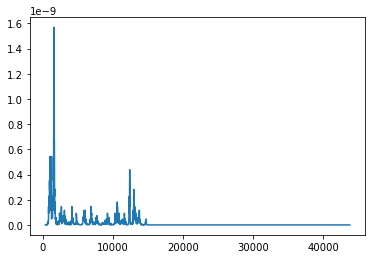

In [21]:
primary_changes.change_series.plot()

Runs as a features resulted in p-values that are constantly smaller than 0. Another feature is tried for the primary axis.

In [19]:
primary_feature_extractor = feature_extraction.RelationalEntropyFE()
primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)
primary_changes = primary_process_drift_detector.get_changes(event_log)
primary_changes

Change points: [1029, 19589, 4999, 399, 33679, 37649, 42899, 2199, 7329, 9889, 6819, 10529, 16169, 14379, 13369, 3259, 36159, 21589, 24919, 3429, 9199, 25589, 11769, 35579, 12669]
Has a change series.

<AxesSubplot:>

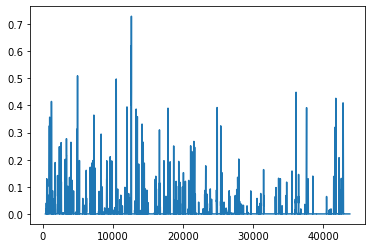

In [20]:
primary_changes.change_series.plot()

Same problem with the relational entropy feature extractor.

So split the log into sublogs.

In [31]:
# splitting the log into 4, resulting into logs of sizes [10952, 10952, 10952, 10953]
# starting from the second log, the first 2*window width of the log is overlapping so that all drifts can be captured
# get start and ends of the sub logs
log_sizes = [10952, 10952, 10952, 10953]
log_start_ends = []
end = -1
for i, log_size in enumerate(log_sizes):
    regular_start = end + 1
    start = regular_start
    if i != 0:
        start -= 2 * primary_window_size
    end = regular_start + log_size - 1
    log_start_ends.append((start, end))
log_start_ends

[(0, 10951), (10552, 21903), (21504, 32855), (32456, 43808)]

In [ ]:
for i, (start, end) in enumerate(log_start_ends):
    traces = event_log[start:end]
    sub_log = EventLog(traces, attributes=event_log.attributes, extensions=event_log.extensions, classifiers=event_log.classifiers,
                omni_present=event_log.omni_present, properties=event_log.properties)
    # save the sub log to file
    write_xes(sub_log, f'{file_path}_sub_{i+1}.xes')
    start = end + 1
    # sleep a second to avoid conflicting writes
    time.sleep(1)

In [33]:
# get the file paths
file_paths = {'part_1': f'{file_path}_sub_1.xes',
                    'part_2':  f'{file_path}_sub_2.xes',
                    'part_3':  f'{file_path}_sub_3.xes',
                    'part_4': f'{file_path}_sub_4.xes',}
parts = list(file_paths.keys())

In [5]:
# load the sub logs
event_logs = {part: xes_importer.apply(file_path) for part, file_path in file_paths.items()}

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 11352/11352 [01:26<00:00, 130.70it/s]


In [8]:
# set to the ProDrift Drift detector
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=primary_window_size,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [9]:
primary_changes_per_part = {}
for part, sub_event_log in event_logs.items():
    # create the change point explainer
    changes = primary_process_drift_detector.get_changes(sub_event_log)
    primary_changes_per_part[part] = changes

exporting log, completed traces :: 100%|██████████| 10951/10951 [01:06<00:00, 164.02it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpdvnlj6pa\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 1770 (Thu Feb 18 07:22:34 CET 2016) after reading 1952 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 4177 (Thu Feb 18 07:50:06 CET 2016) after reading 4218 traces.\r\n\r\n\r\n(3) Sudden drift detected at trace: 5913 (Thu Apr 14 13:23:36 CEST 2016) after reading 7738 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 11351/11351 [01:18<00:00, 144.31it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmp_ziafcn3\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 786 (Thu Feb 18 07:27:56 CET 2016) after reading 990 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 1655 (Thu Feb 18 07:52:51 CET 2016) after reading 1730 traces.\r\n\r\n\r\n(3) Sudden drift detected at trace: 2163 (Wed Mar 30 07:42:27 CEST 2016) after reading 2725 traces.\r\n\r\n\r\n(4) Sudden drift detected at trace: 4751 (Fri Jan 06 13:38:43 CET 2017) after reading 4824 traces.\r\n\r\n\r\n(5) Sudden drift detected at trace: 6461 (Fri Jan 06 14:23:39 CET 2017) after reading 6799 traces.\r\n\r\n\r\n(6) Sudden drift detected at trace: 8716 (Fri Jan 27 06:40:19 CET 2017) after reading 10607 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 11351/11351 [01:12<00:00, 156.05it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpi1yb8_vl\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 1959 (Fri Jan 06 13:38:47 CET 2017) after reading 2088 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 3894 (Fri Jan 06 14:24:26 CET 2017) after reading 5785 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 11352/11352 [01:15<00:00, 150.14it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmp55ajejan\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 3098 (Fri Jan 05 15:24:53 CET 2018) after reading 3217 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 6550 (Fri Jan 05 16:05:42 CET 2018) after reading 6665 traces.\r\n\r\n\r\n(3) Sudden drift detected at trace: 8096 (Fri Jan 05 16:24:32 CET 2018) after reading 8380 traces.\r\n\r\n\r\n'


In [38]:
# get the change points (they need to be adjusted by the offset of each part)
primary_change_points = []
for i, (start, end) in enumerate(log_start_ends):
    part = parts[i]
    relative_cps = primary_changes_per_part[part].change_points
    for relative_cp in relative_cps:
        absolute_cp = relative_cp + start
        primary_change_points.append(absolute_cp)
primary_change_points

[1770,
 4177,
 5913,
 11338,
 12207,
 12715,
 15303,
 17013,
 19268,
 23463,
 25398,
 35554,
 39006,
 40552]

Results from ProDrift:

Part 1 (Start: trace 0)

![alt text](results/bpic_2018/pro_drift/part_1.png "Primary Change Series Part 1")

Part 2 (Start: trace 10552)

![alt text](results/bpic_2018/pro_drift/part_2.png "Primary Change Series Part 2")

Part 3 (Start: trace 21504)

![alt text](results/bpic_2018/pro_drift/part_3.png "Primary Change Series Part 3")

Part 4 (Start: trace 32456)

![alt text](results/bpic_2018/pro_drift/part_4.png "Primary Change Series Part 4")

All change points: 
```Python
[1770, 4177, 5913, 11338, 12207, 12715, 15303, 17013, 19268,
 23463, 25398, 35554, 39006, 40552]
```

In [18]:
# get the timestamps of the change points
primary_change_points = [1770, 4177, 5913, 11338, 12207, 12715, 15303, 17013, 19268, 23463, 25398, 35554, 39006, 40552]
primary_change_points_timestamps = []
for change_point in primary_change_points:
    primary_change_points_timestamps.append(event_log[change_point][0]['time:timestamp'])
print('\n'.join([str(ts) for ts in primary_change_points_timestamps]))

2015-05-05 00:00:00+02:00
2015-04-22 00:00:00+02:00
2015-04-27 00:00:00+02:00
2015-04-24 00:00:00+02:00
2015-04-26 00:00:00+02:00
2015-04-15 00:00:00+02:00
2016-04-12 00:00:00+02:00
2016-04-27 00:00:00+02:00
2016-05-06 00:00:00+02:00
2016-04-25 00:00:00+02:00
2016-04-21 00:00:00+02:00
2017-05-12 00:00:00+02:00
2017-05-11 00:00:00+02:00
2017-05-11 00:00:00+02:00


In [19]:
# the secondary drift detector is set to a True Known Drift Detector with the change points that where 
# extracted through ProDrift
primary_process_drift_detector = drift_detection.TrueKnownDD(primary_change_points)

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [20]:
secondary_window_size = 200
secondary_slide_by = 20

max_distance = 300

secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)

secondary_phi = secondary_window_size / secondary_slide_by * 0.5
secondary_rho = 1
secondary_threshold = 0.05

change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_type_list,
                                                                         secondary_window_generator, 
                                                                         change_point_extractor,
                                                                         min_samples_per_test=0)

# change the population comparer to hellingers distance
for sdd in secondary_drift_detectors:
    sdd.population_comparer = population_comparison.HellingerDistancePC()

In [21]:
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)

## Analysis
Plot the results. Because there are so many attribute values, split the plot into subplots.

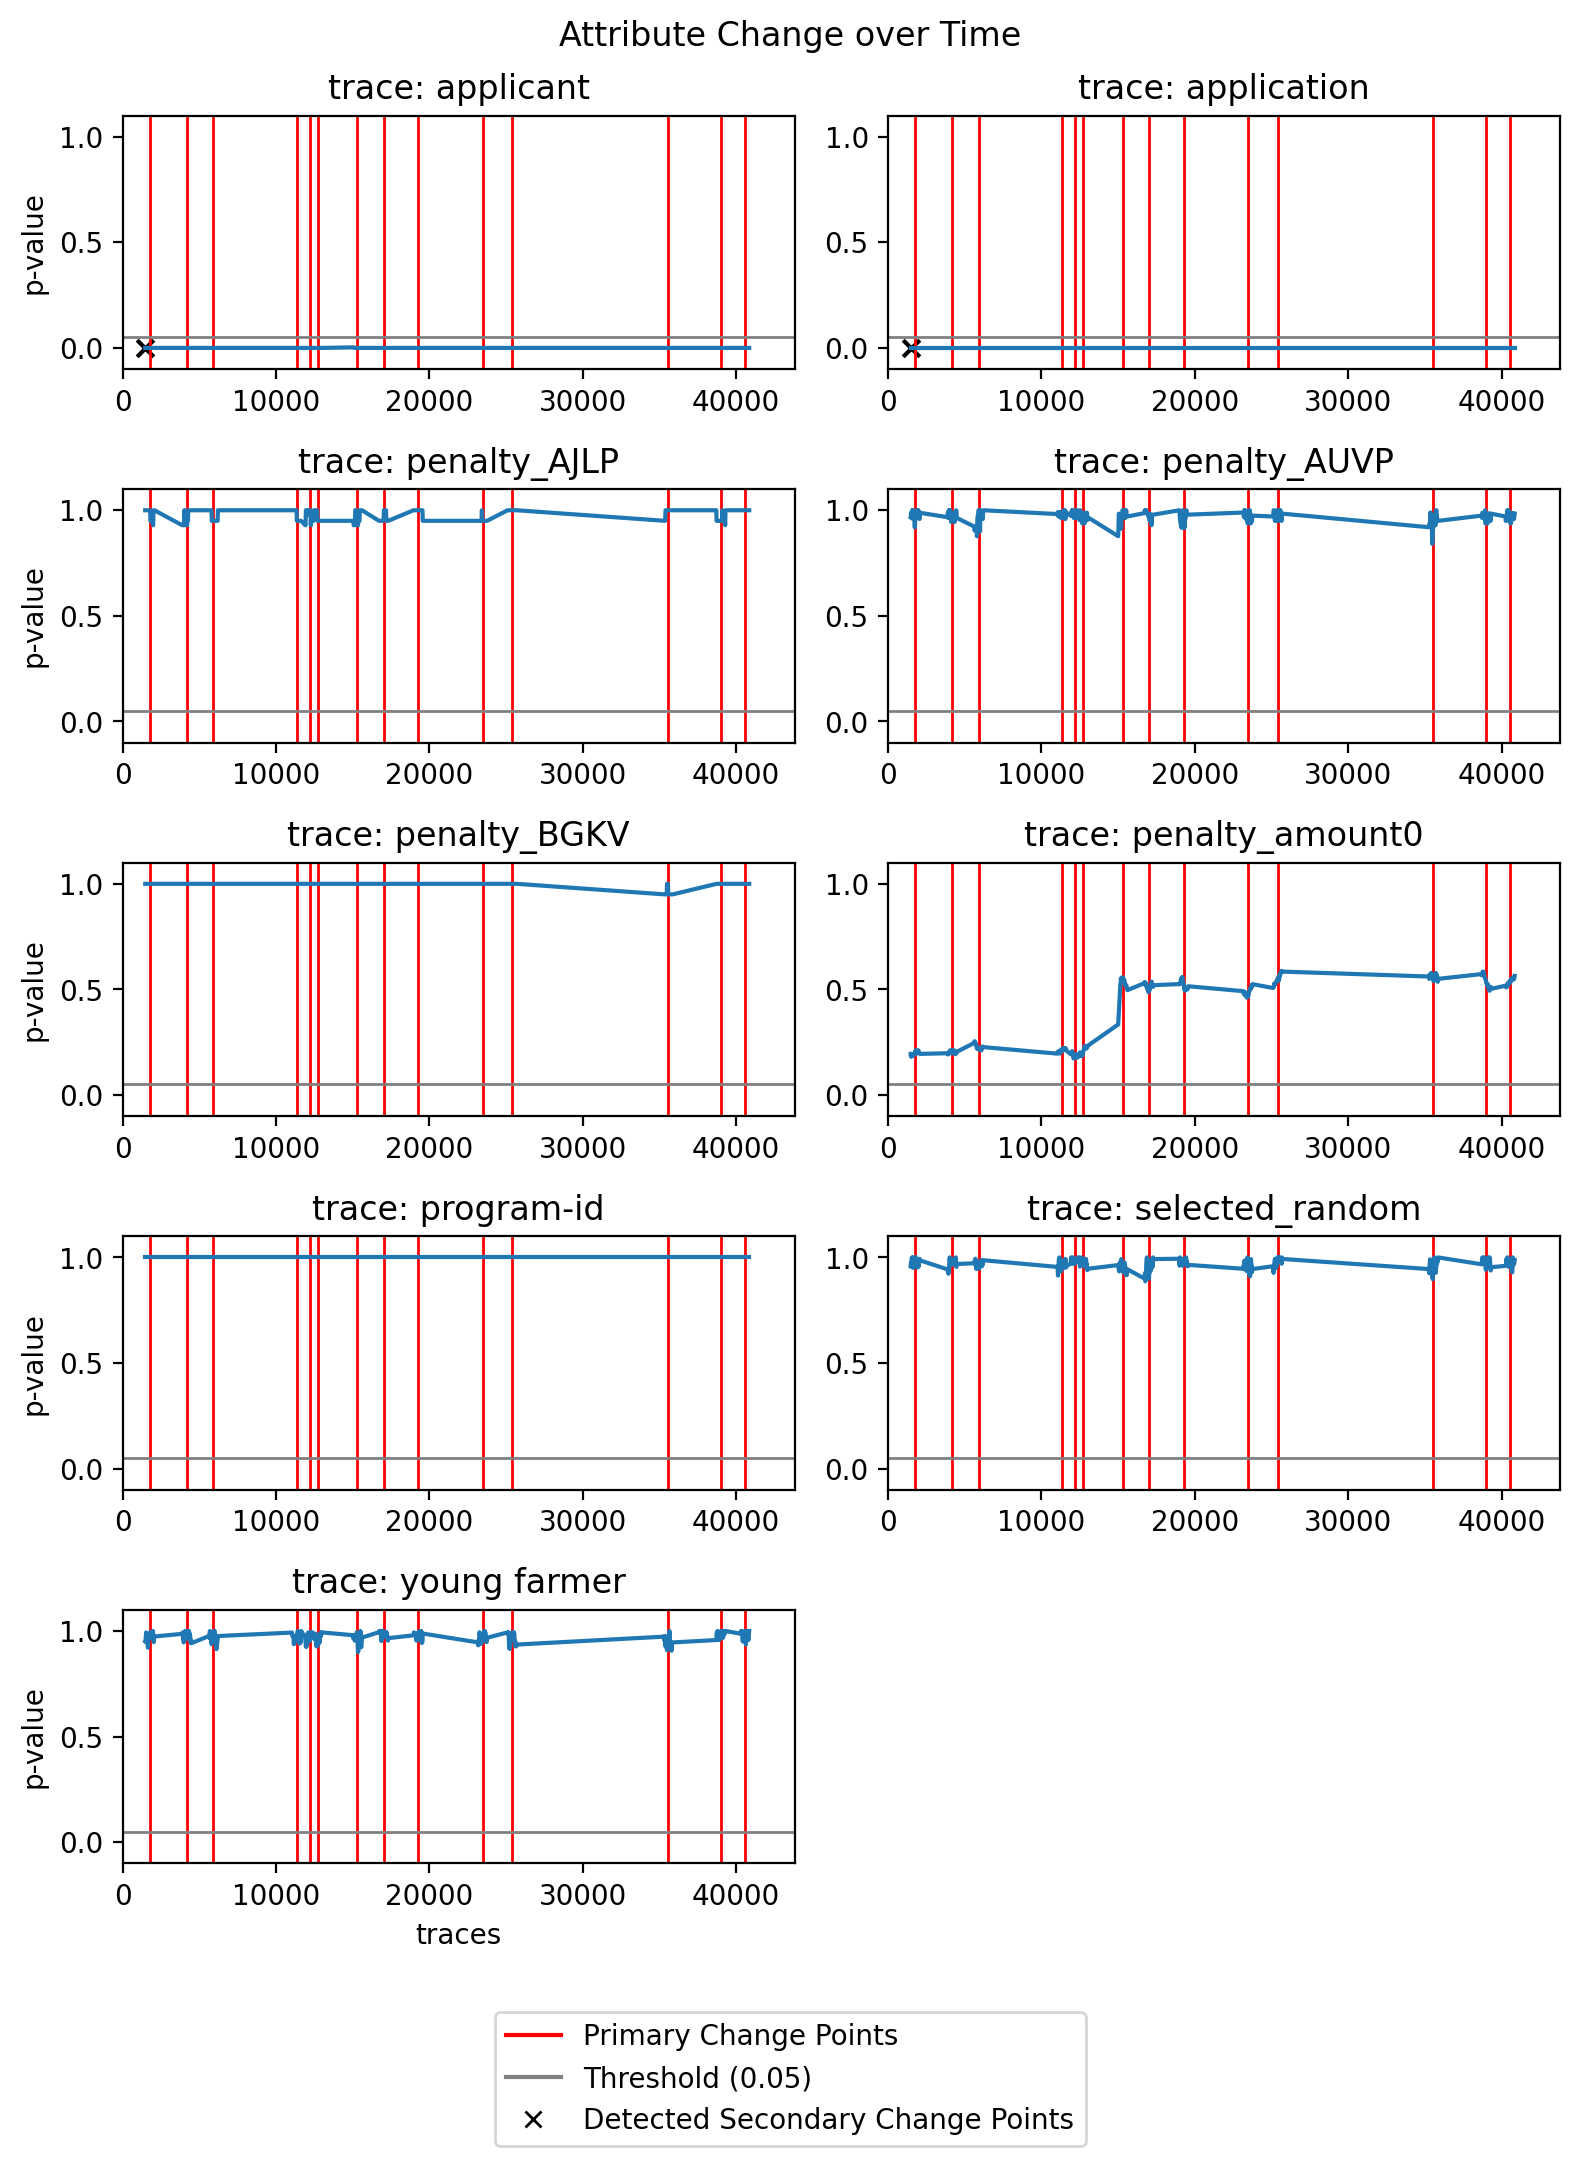

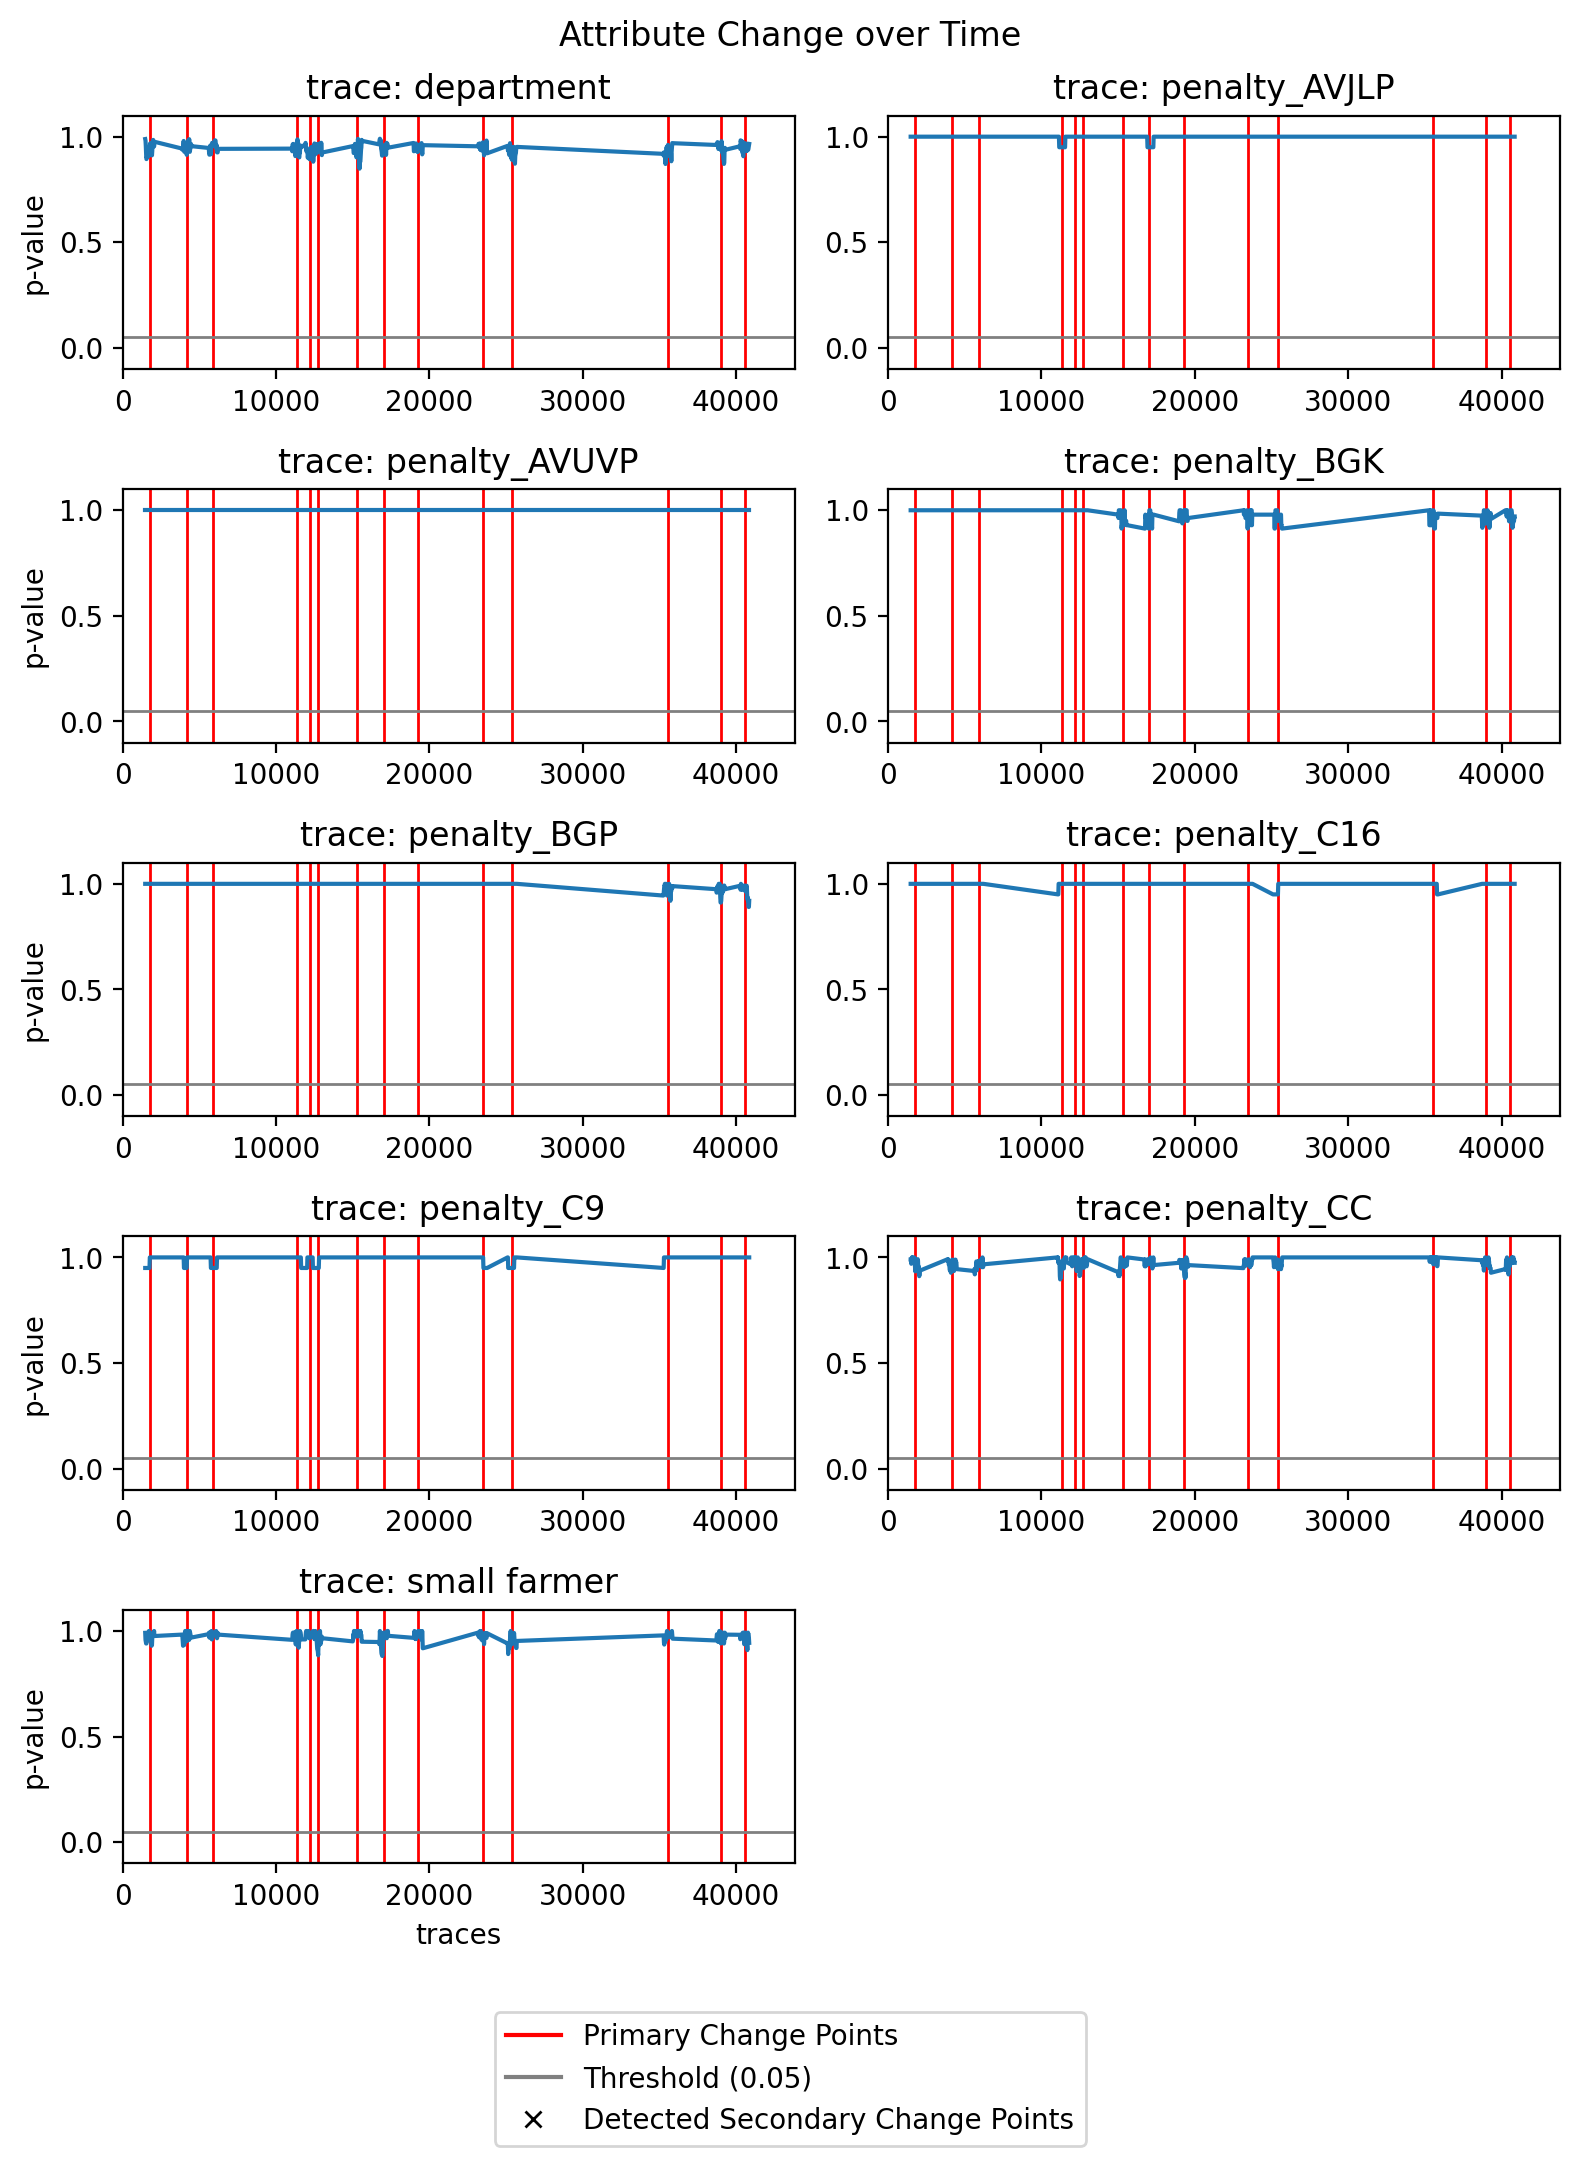

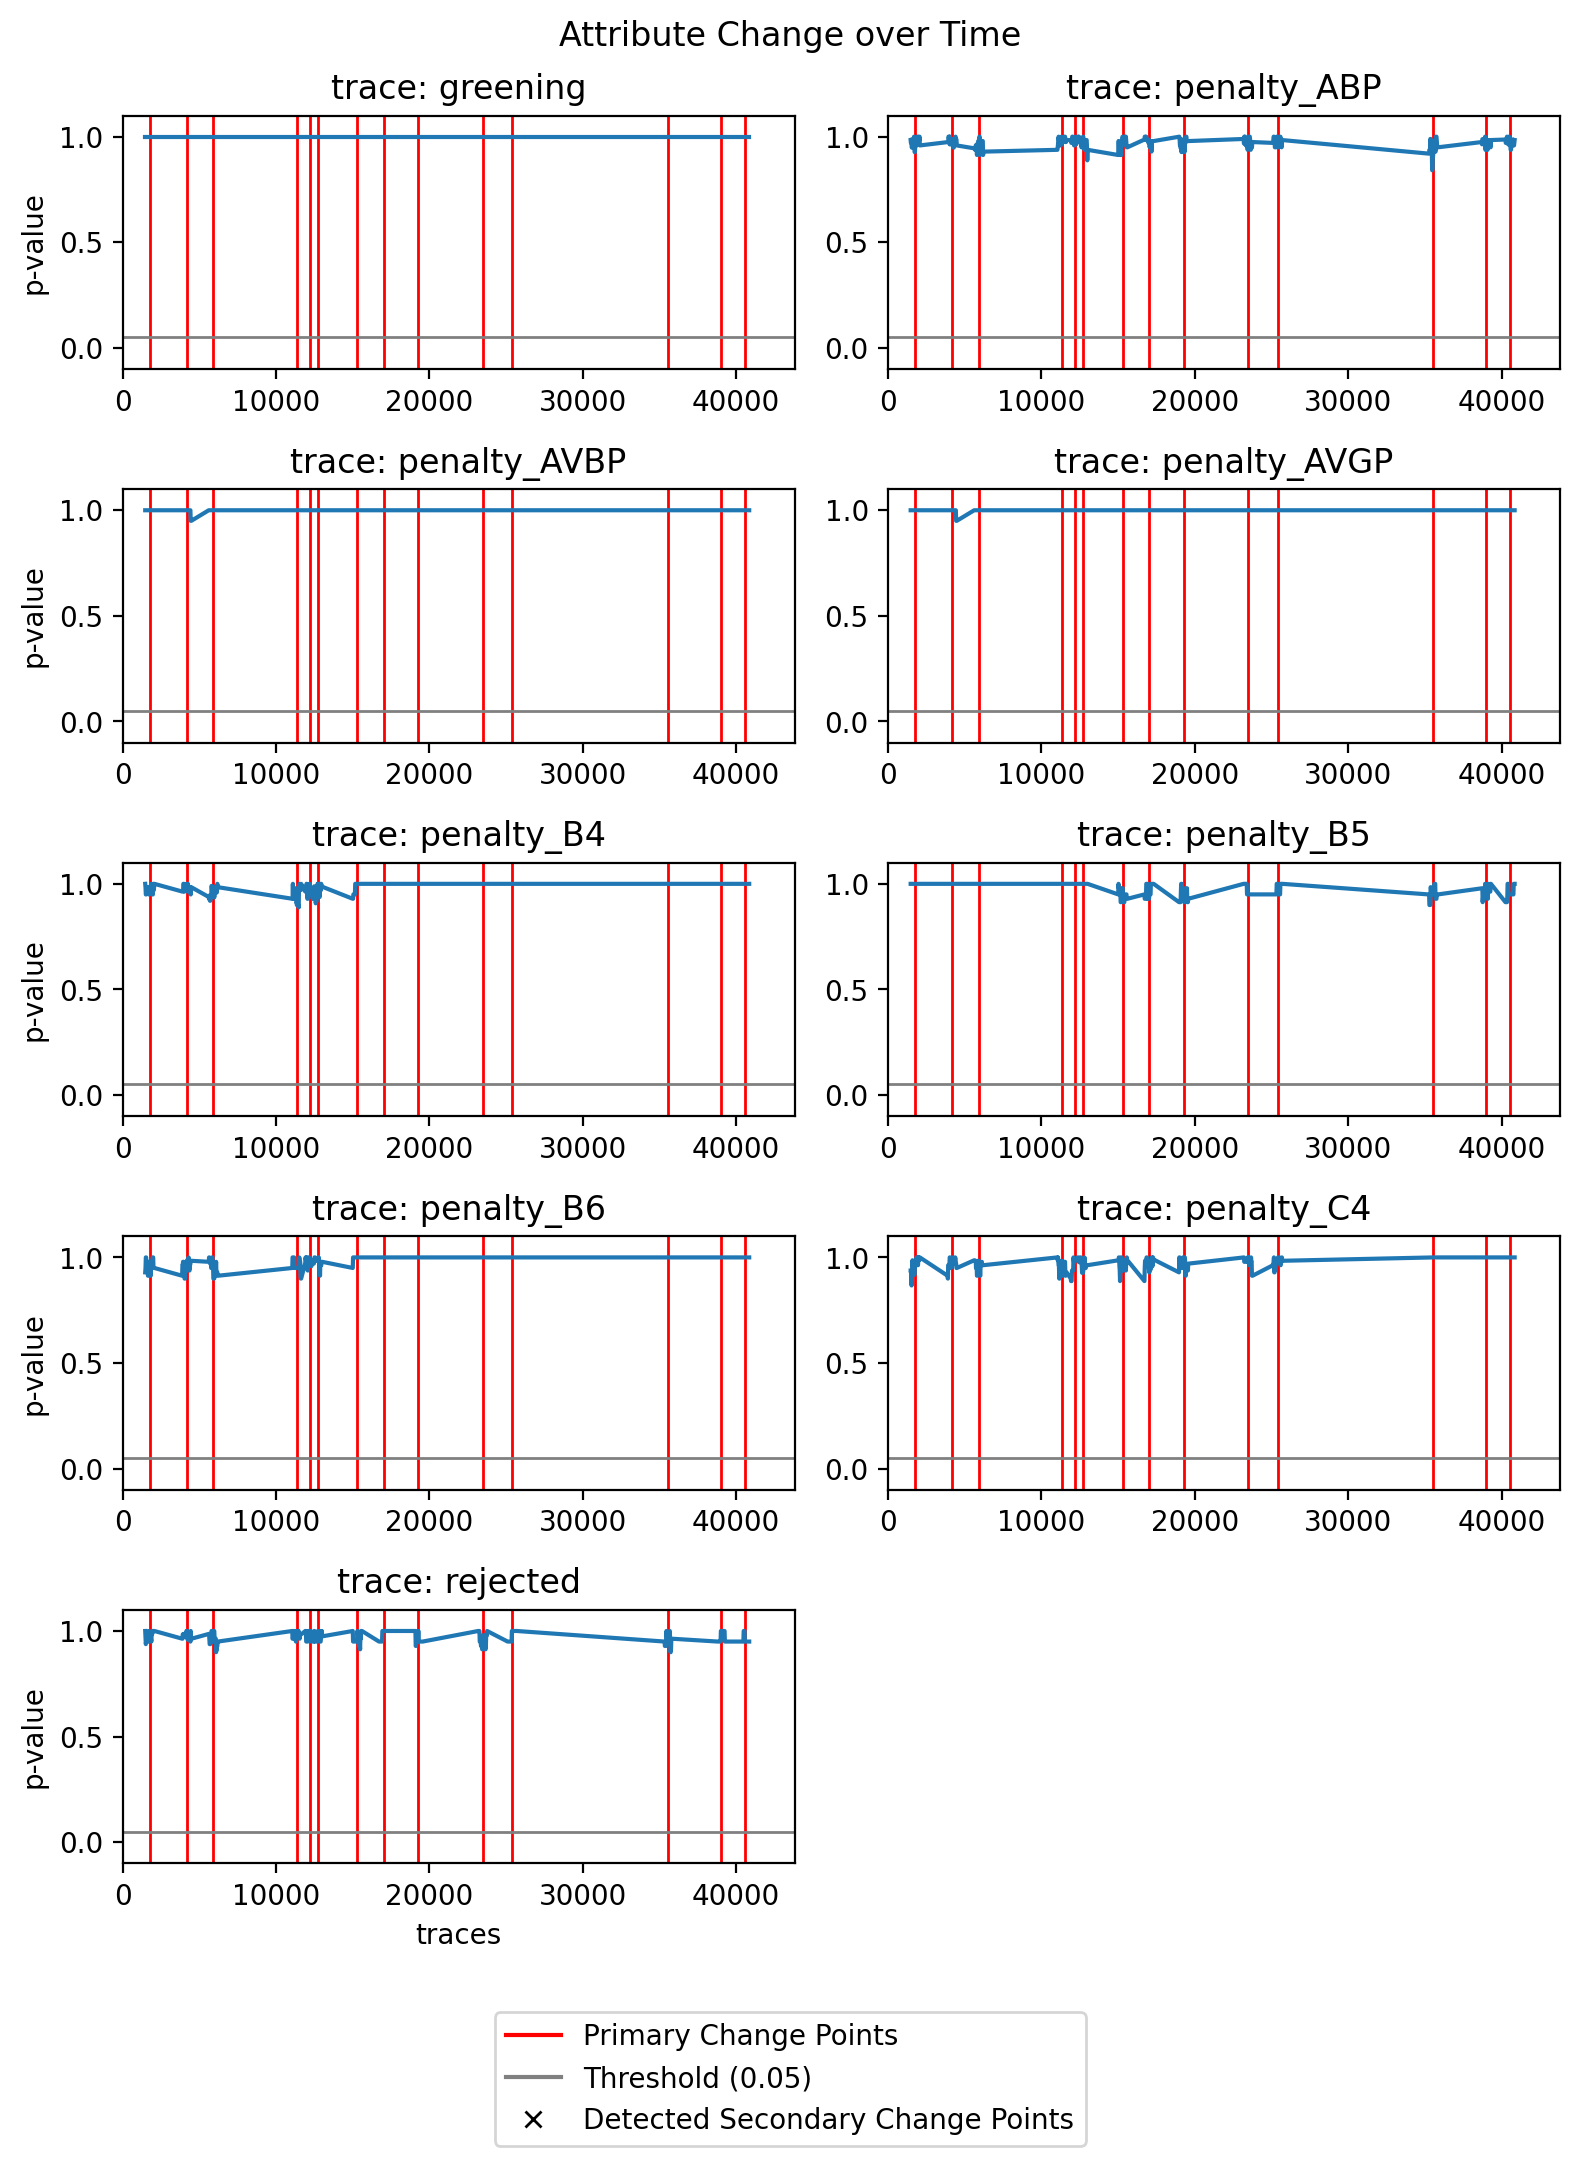

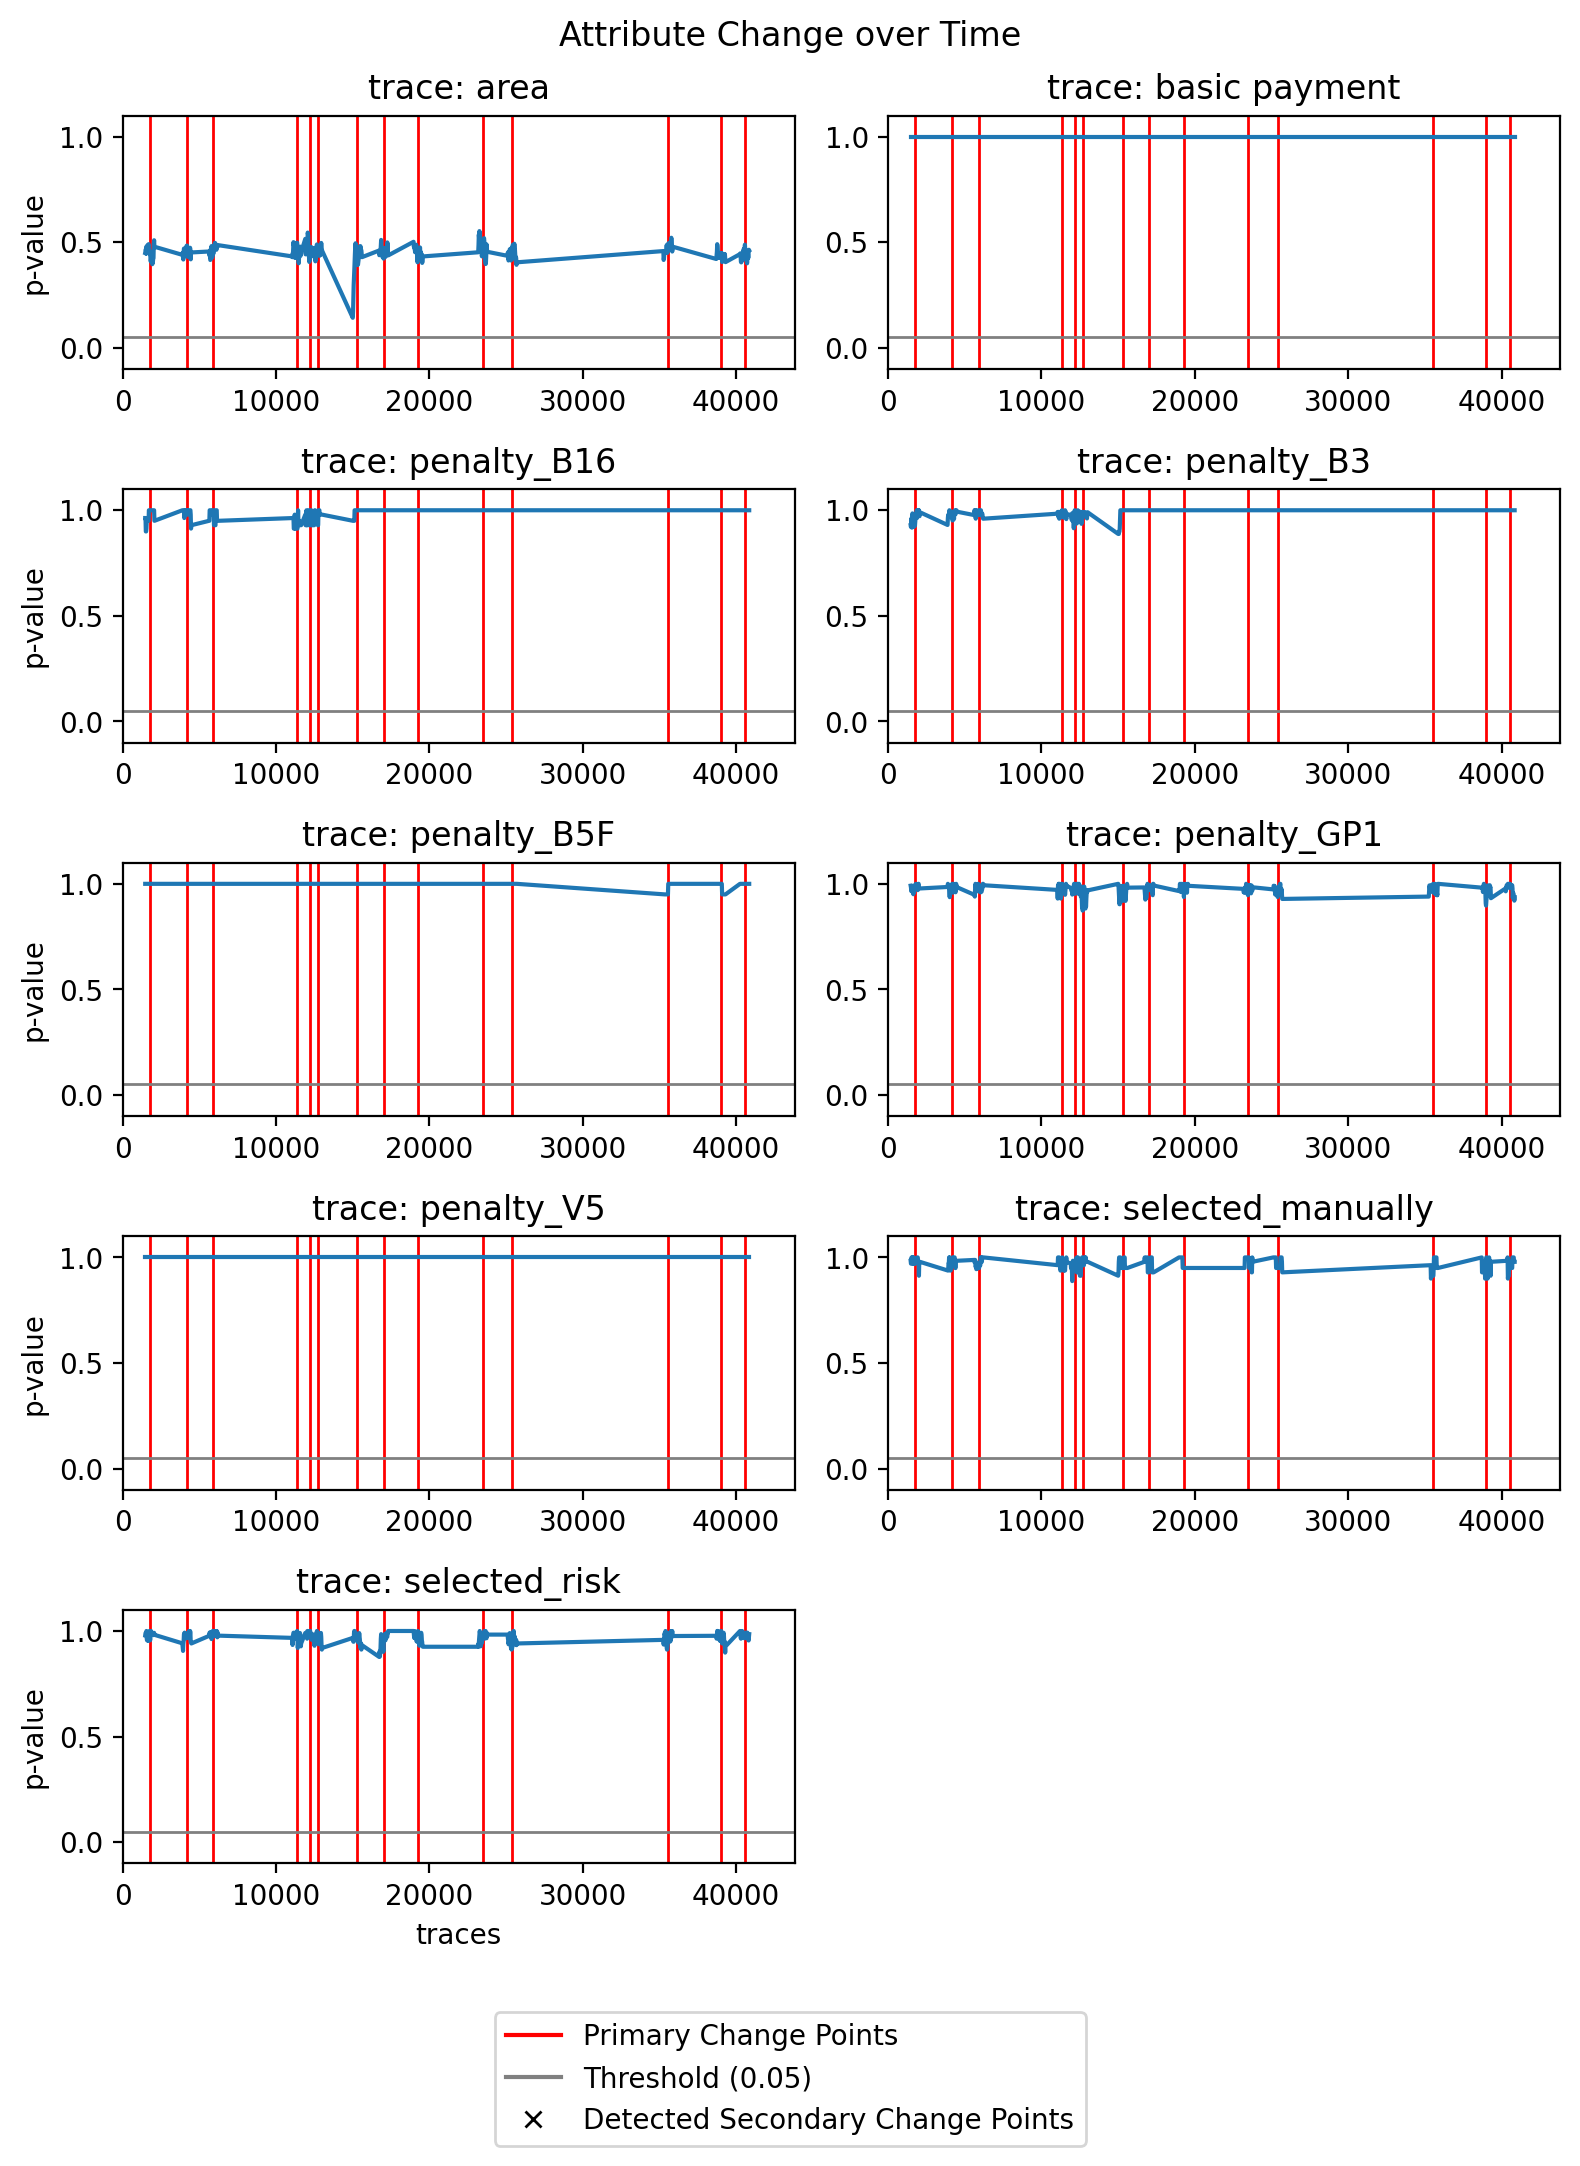

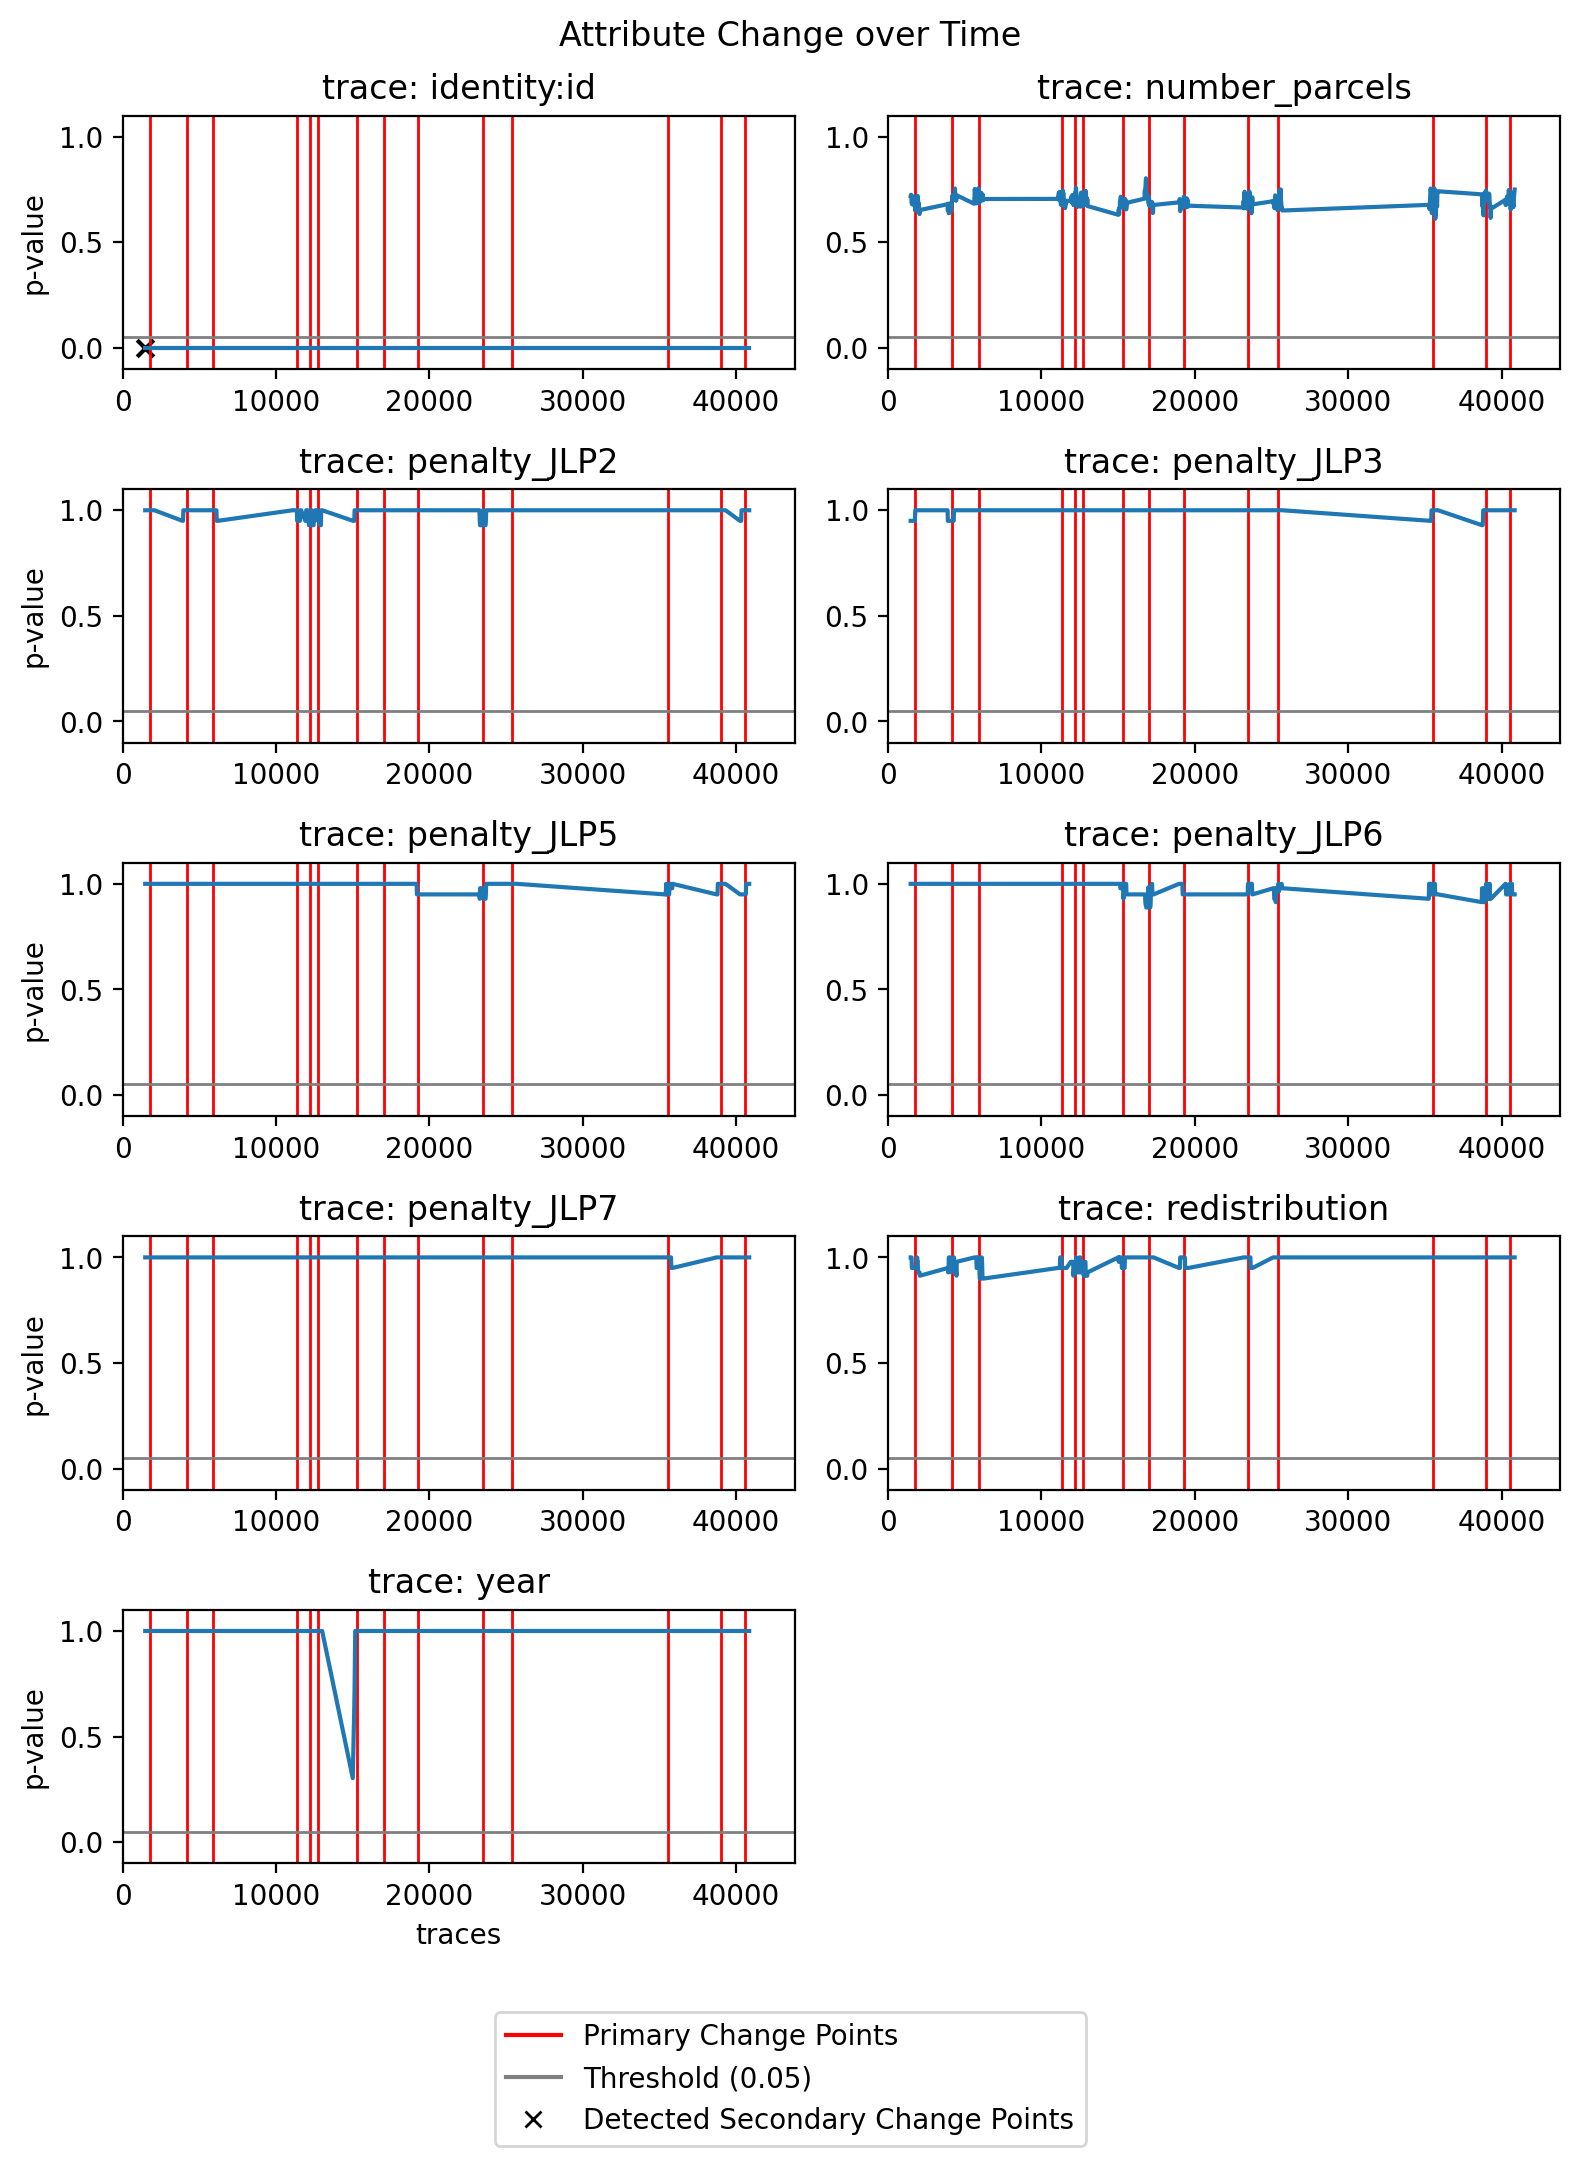

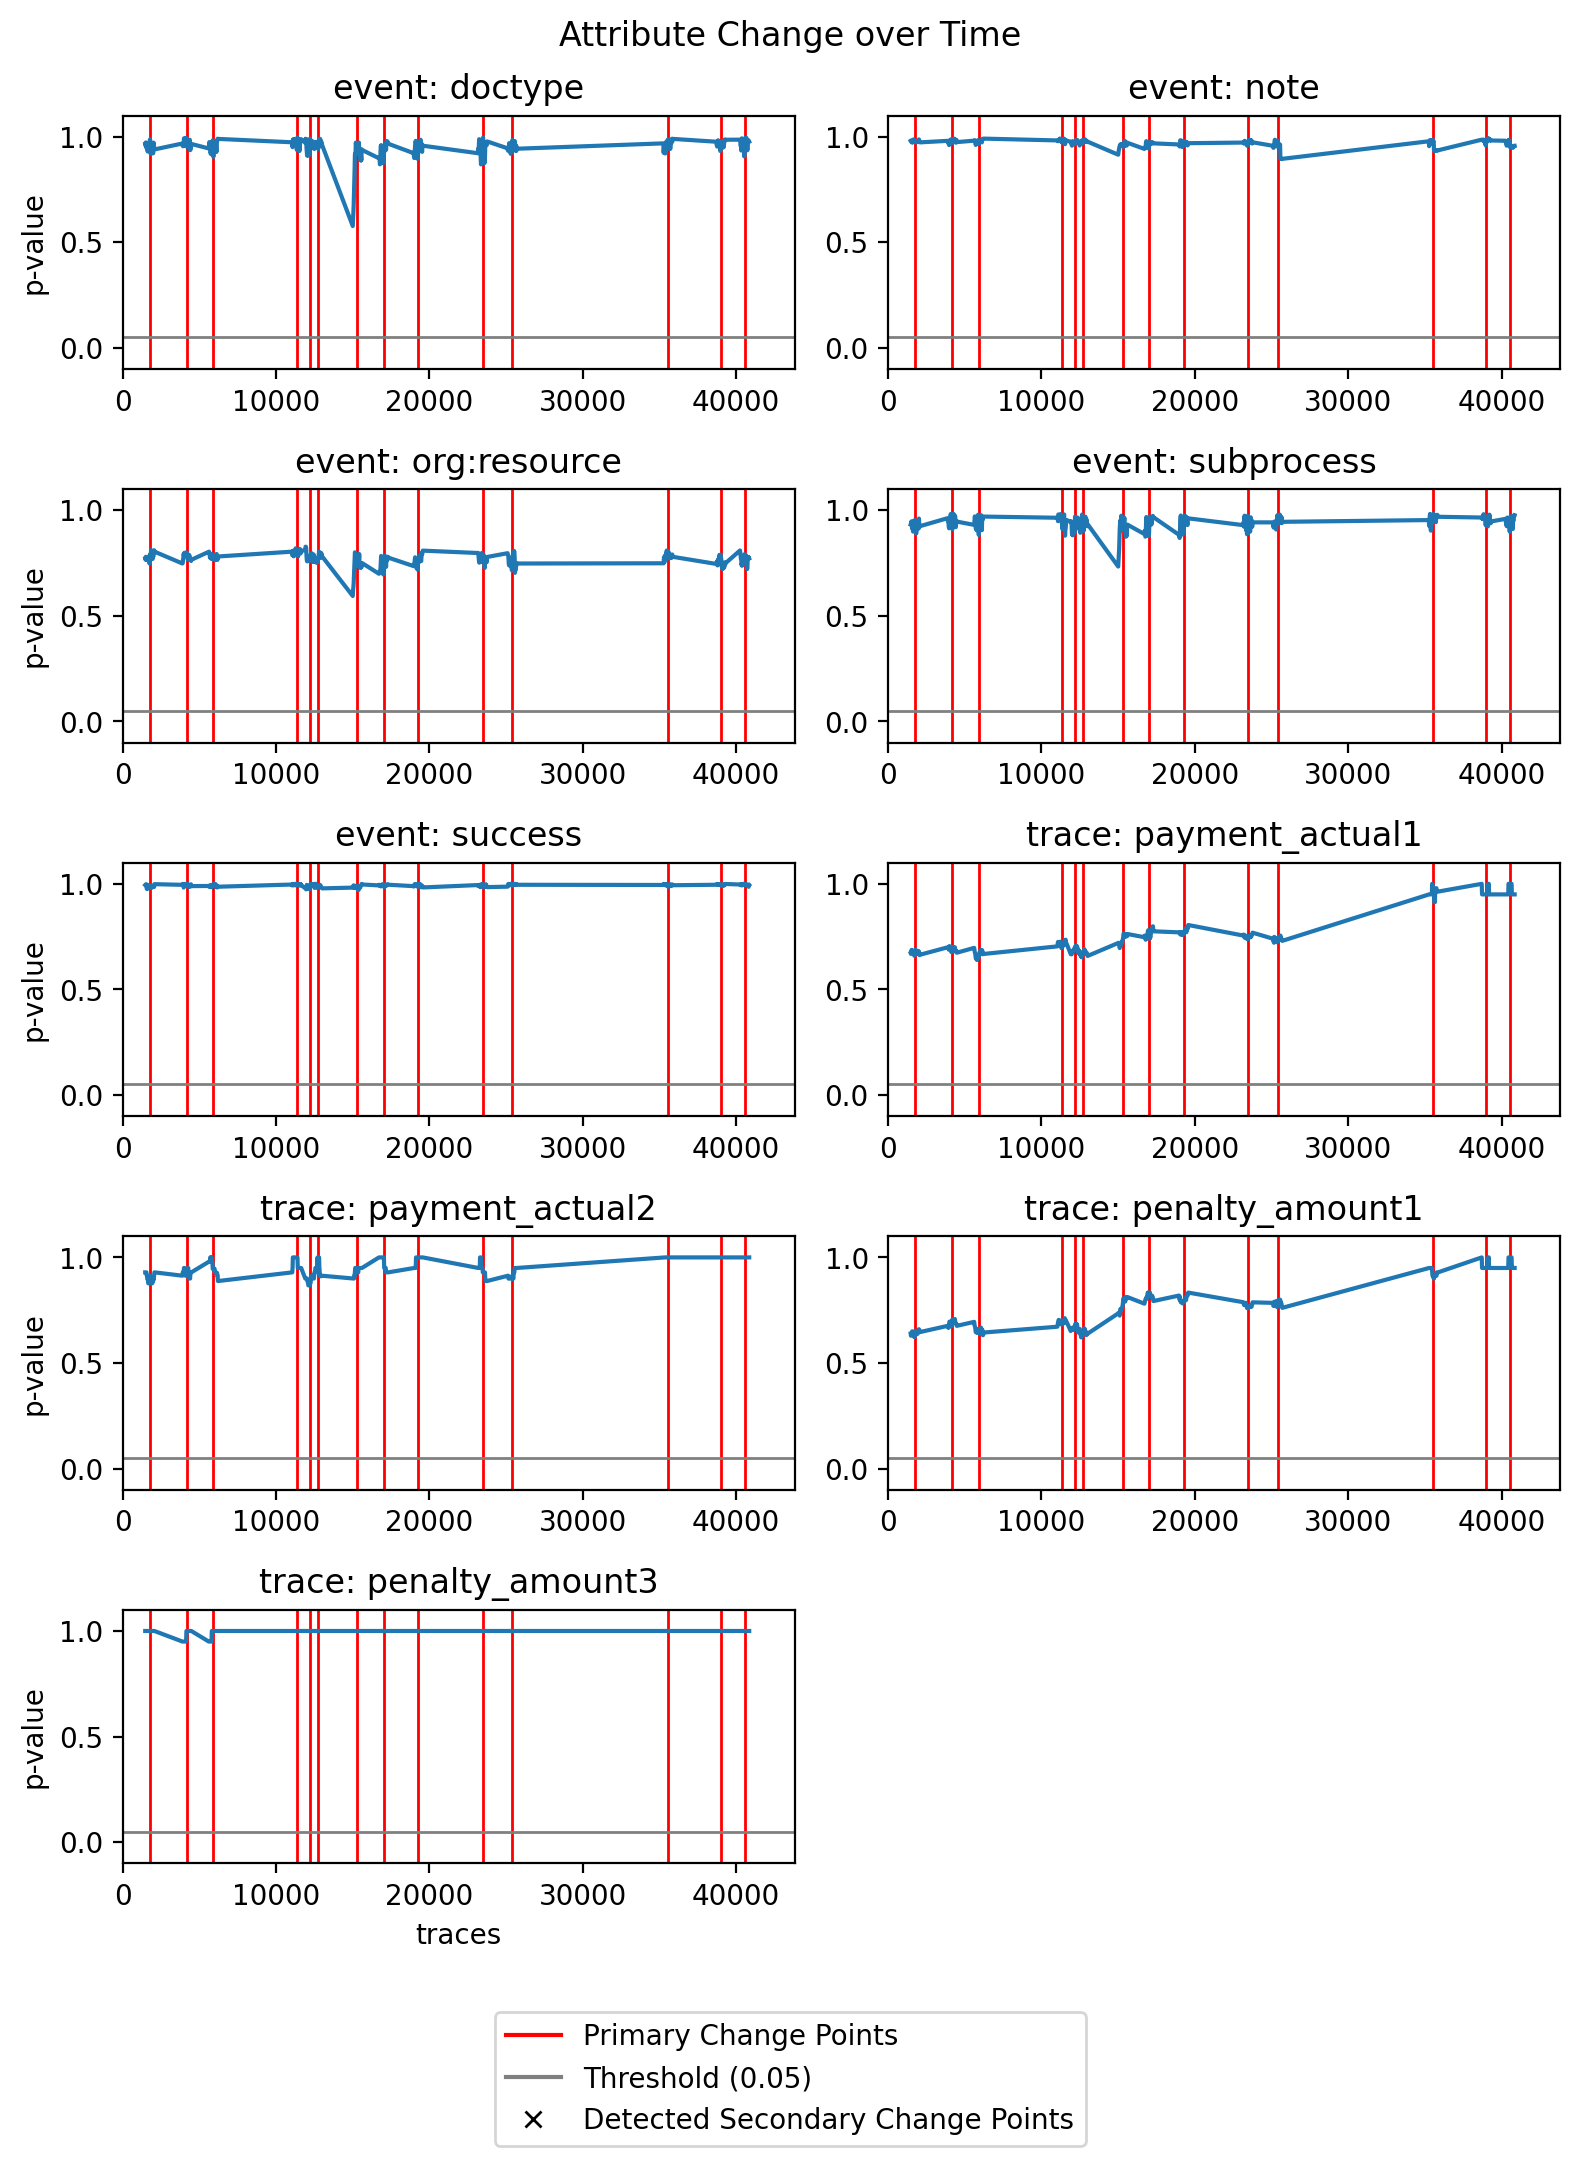

In [34]:
secondary_result_keys = list(changes.secondary_dd_result_dictionary.keys())
for start, end in [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49), (50, 59)]:
    selected_secondary_result_keys = secondary_result_keys[start:end]
    # filter for the selected keys
    selected_secondary_results = {key:value for key, value in changes.secondary_dd_result_dictionary.items() if key in selected_secondary_result_keys}

    # create a new change explanation object
    selected_changes = drift_explanation.DriftExplanationResult(changes.primary_dd_result, selected_secondary_results, None)
    selected_changes.plot(offset_legend=-0.09)

In [1]:
import numpy as np
def get_ideal_window_size(event_log, feature_extractor, min_count=5, threshold=0.8, num_samples=100, start_width=5, max_width=1000):
    # get the starts for the sample windows
    max_window_start = len(event_log) - max_width - 1
    sample_starts = np.random.randint(0, max_window_start, num_samples)
    optimal_size_found = False
    window_width = start_width
    while window_width < max_width and not optimal_size_found:
        count_satisfies_min_count = 0
        for sample_start in sample_starts:
            # get the attribute from the event log
            sub_traces = event_log[sample_start:sample_start+window_width]
            sub_log = EventLog(sub_traces, attributes=event_log.attributes, extensions=event_log.extensions, classifiers=event_log.classifiers,
                omni_present=event_log.omni_present, properties=event_log.properties)
            feature_values = feature_extractor.extract(sub_log)
            # get number of unique feature values
            unique_value_counts = pd.Series(feature_values).value_counts()
            if len(unique_value_counts) != 0 and not min(unique_value_counts) < 5:
                count_satisfies_min_count += 1
        percentage_satisfies_min_count = count_satisfies_min_count / num_samples
        if percentage_satisfies_min_count > threshold:
            optimal_size_found = True
        else:
            window_width += 1
    return window_width

In [3]:
all_categorical_attributes = [(attribute_name, attribute_level, attribute_type) for attribute_name, attribute_level, attribute_type in attribute_level_type_list if attribute_type == 'categorical']

NameError: name 'attribute_level_type_list' is not defined

In [2]:
ideal_window_sizes = {}
for (attribute_name, attribute_level, attribute_type) in all_categorical_attributes:
    fe = feature_extraction.AttributeFE(attribute_level, attribute_name)
    ideal_window_size = get_ideal_window_size(event_log, fe, num_samples=1)
    ideal_window_sizes[(attribute_name, attribute_level, attribute_type)] = ideal_window_size
ideal_window_sizes

NameError: name 'all_categorical_attributes' is not defined

In [48]:
for (attribute_name, attribute_level, attribute_type) in all_categorical_attributes:
    feature_extractor = feature_extraction.AttributeFE(attribute_name, attribute_level)
    print(get_ideal_window_size(event_log, feature_extractor, num_samples=10))

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [39]:
get_ideal_window_size(event_log, secondary_drift_detectors[0].feature_extractor, num_samples=10)
get_ideal_window_size(event_log, secondary_drift_detectors[1].feature_extractor, num_samples=10)

1000

In [22]:
def compare_attributes_in_windows(event_log, attribute_level, attribute_name, window_a_start, window_b_start, window_width = 200):
    # Analysis for feature 'Includes_subCases'
    # compare two windows with this feature
    print(f'Analysis of {attribute_level} attribute {attribute_name}')
    window_generator = windowing.FixedWG(window_width, window_offset=window_b_start-window_a_start, slide_by=1)
    window_a, window_b = next(window_generator.get_windows(event_log, start=window_a_start))

    feature_extractor = feature_extraction.AttributeFE(attribute_level=attribute_level, attribute_name=attribute_name)

    features_window_a = feature_extractor.extract(window_a.log)
    features_window_b = feature_extractor.extract(window_b.log)
    print('Values in Window a')
    display(pd.Series(features_window_a).value_counts())
    print('Values in Window b')
    display(pd.Series(features_window_b).value_counts())

In [23]:
compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'caseStatus', 0, 400)

Analysis of trace attribute caseStatus
Values in Window a


O    158
G     42
dtype: int64

Values in Window b


G    148
O     52
dtype: int64

In [24]:
compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'Includes_subCases', 0, 400)

Analysis of trace attribute Includes_subCases
Values in Window a


Attribute not defined.    195
J                           4
N                           1
dtype: int64

Values in Window b


J    157
N     43
dtype: int64

In [25]:
compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'last_phase', 0, 400)

Analysis of trace attribute last_phase
Values in Window a


Beschikking verzonden               109
Aanvraag ontvangen                   29
Zaak afgehandeld                     20
Buiten behandeling gelaten           12
Besluit onherroepelijk                7
Aanvullende gegevens gevraagd         6
Aanvullende gegevens ontvangen        4
Procedure tussentijds beëindigd       3
Vergunning verleend                   3
Procedure afgebroken                  2
Ontwerpbesluit genomen                1
Besluit genomen                       1
Conceptontwerpbeschikking gereed      1
Advies bekend                         1
Proceduretermijn verlengd             1
dtype: int64

Values in Window b


Vergunning verleend            143
Procedure afgebroken            21
Aanvraag ontvangen              12
Advies bekend                    6
Besluit genomen                  4
Vergunning onherroepelijk        3
Ontwerpbesluit genomen           3
Besluit onherroepelijk           2
Aanvraag ontvankelijk            2
Zaak afgehandeld                 1
Proceduretermijn opgeschort      1
Beschikking verzonden            1
Vergunning geweigerd             1
dtype: int64

In [26]:
compare_attributes_in_windows(event_logs['mun_1'], 'event', 'org:resource', 0, 400)

Analysis of event attribute org:resource
Values in Window a


560872      2422
560912      1631
11744364    1338
2670601     1323
9264148      718
560890       584
560950        93
12941730      48
560464        29
6             26
11345232      19
10716070      10
560462         7
4936828        5
560925         5
dtype: int64

Values in Window b


3273854    2584
560872     1765
2670601    1143
560890     1008
560912      339
560925      319
560462      311
560894      264
560589      147
560881       59
560999       46
560950       26
560464        9
3175153       9
4936828       4
dtype: int64

In [27]:
compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'termName', 0, 400)

Analysis of trace attribute termName
Values in Window a


Termijn bezwaar en beroep 1                113
Termijn tot besluit                         42
Attribute not defined.                      29
Termijn tot bezwaar buiten behandeling       9
Termijn aanvullende gegevens                 3
Termijn tot besluit omgezet 2                1
Termijn tot besluit na geen zienswijzen      1
Termijn tot besluit omgezet                  1
Termijn tot besluit verlengd                 1
dtype: int64

Values in Window b


Termijn bezwaar en beroep 1                128
Attribute not defined.                      34
Termijn tot besluit                         26
Termijn aanvullende gegevens                 4
Termijn tot besluit verlengd                 3
Termijn tot besluit omgezet                  2
Termijn bezwaar en beroep 2                  1
Termijn tot besluit na geen zienswijzen      1
Termijn ter inzage buiten behandeling        1
dtype: int64

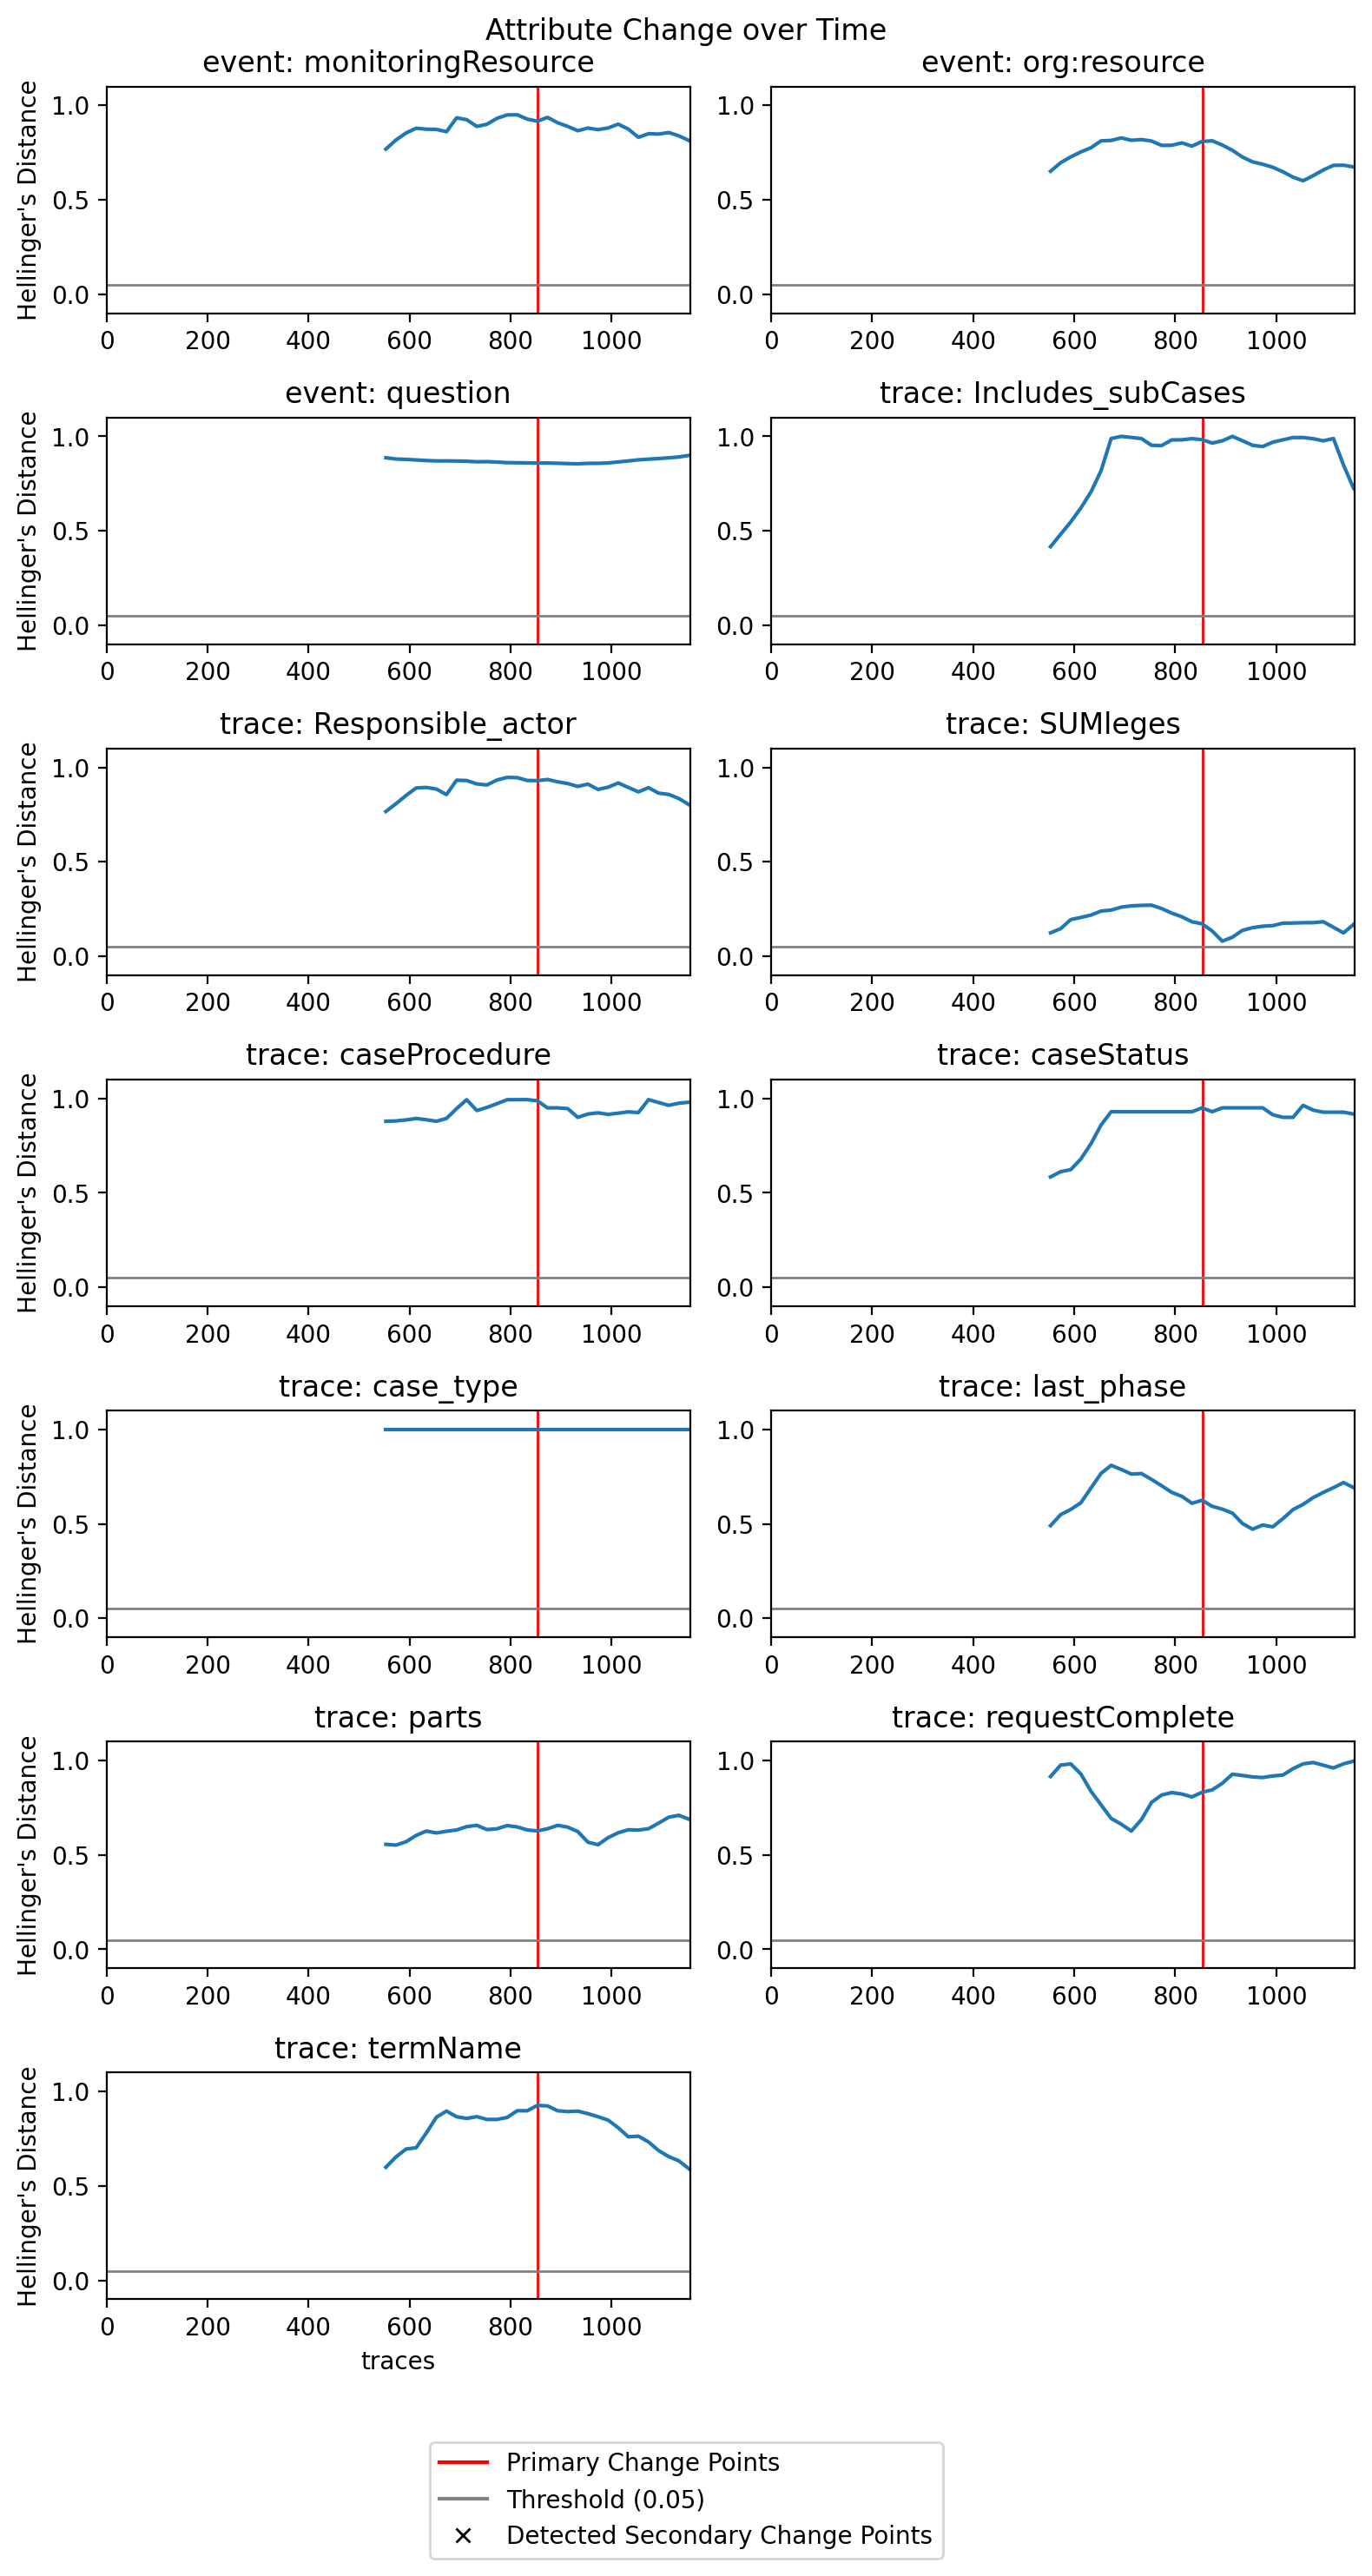

In [28]:
hellinger_distance_explanations['mun_3'].plot(ylabel='Hellinger\'s Distance', offset_legend=-0.07)
pass

In [29]:
compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'last_phase', 450, 1000, window_width=100)

Analysis of trace attribute last_phase
Values in Window a


Vergunning verleend       77
Procedure afgebroken      11
Aanvraag ontvangen         5
Ontwerpbesluit genomen     2
Aanvraag ontvankelijk      1
Besluit onherroepelijk     1
Beschikking verzonden      1
Besluit genomen            1
Advies bekend              1
dtype: int64

Values in Window b


Beschikking verzonden              57
Zaak afgehandeld                   24
Besluit onherroepelijk              9
Procedure afgebroken                4
Buiten behandeling gelaten          3
Procedure tussentijds beëindigd     1
Advies bekend                       1
Aanvullende gegevens ontvangen      1
dtype: int64

In [30]:
compare_attributes_in_windows(event_logs['mun_3'], 'trace', 'requestComplete', 400, 600, window_width=100)

Analysis of trace attribute requestComplete
Values in Window a


TRUE     72
FALSE    28
dtype: int64

Values in Window b


TRUE     80
FALSE    20
dtype: int64